«Модель прогнозирования стоимости жилья для агентства недвижимости»

Постановка задачи — разработать модель, которая позволила бы агентству
недвижимости обойти конкурентов по скорости и качеству совершения
сделок.


Описание данных:

'status' — статус продажи;

'private pool' и 'PrivatePool' — наличие собственного бассейна;

'propertyType' — тип объекта недвижимости;

'street' — адрес объекта;

'baths' — количество ванных комнат;

'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);

'fireplace' — наличие камина;

'city' — город;

'schools' — сведения о школах в районе;

'sqft' — площадь в футах;

'zipcode' — почтовый индекс;

'beds' — количество спален;

'state' — штат;

'stories' — количество этажей;

'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);

'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [332]:
# импортируем библиотеки, потребующиеся нам в дальнейшей работе
import pandas as pd
import numpy as np
import ydata_profiling
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import category_encoders as ce
import pickle
import numpy as np
import ydata_profiling
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import category_encoders as ce
import pickle

1. Знакомство с данными, базовый анализ, EDA

In [333]:
data = pd.read_csv('data.csv')
display(data.head())
data.info()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Поиск дубликатов

In [334]:
#Проверка на наличие дубликатов
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'число найденных дубликатов: {data_duplicates.shape[0]}')

число найденных дубликатов: 50


In [335]:
#Удалим дубликаты
data = data.drop_duplicates(ignore_index=True)

In [336]:
#Проверка на удаление дубликатов. 
data_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'результирующее число записей: {data_dedupped.shape[0]}')

результирующее число записей: 377135


Поиск пропусков

In [337]:
missing_data = data.isnull().sum()

# Выводим столбцы, которые содержат пропуски и их количество (в процентах)
for column_name, missing_count in missing_data.items():
    if missing_count > 0:
        percentage = (missing_count / len(data)) * 100
        print(f'{column_name}: {missing_count} пропусков ({percentage:.2f}% от общего числа данных в столбце)')

status: 39917 пропусков (10.58% от общего числа данных в столбце)
private pool: 372954 пропусков (98.89% от общего числа данных в столбце)
propertyType: 34733 пропусков (9.21% от общего числа данных в столбце)
street: 2 пропусков (0.00% от общего числа данных в столбце)
baths: 106308 пропусков (28.19% от общего числа данных в столбце)
fireplace: 274024 пропусков (72.66% от общего числа данных в столбце)
city: 34 пропусков (0.01% от общего числа данных в столбце)
sqft: 40550 пропусков (10.75% от общего числа данных в столбце)
beds: 91254 пропусков (24.20% от общего числа данных в столбце)
stories: 150674 пропусков (39.95% от общего числа данных в столбце)
mls-id: 352193 пропусков (93.39% от общего числа данных в столбце)
PrivatePool: 336825 пропусков (89.31% от общего числа данных в столбце)
MlsId: 66869 пропусков (17.73% от общего числа данных в столбце)
target: 2480 пропусков (0.66% от общего числа данных в столбце)


Исходя из данных представленных выше, выявлены столбцы с наибольшим количеством пропусков: private pool, mls-id, PrivatePool. Столбцы с таким количеством пропусков не дают полезной информации при прогнозировании, от таких столбцов необходимо избавляться.

In [338]:
# посмотрим что содержится в private pool и PrivatePool
print(data['private pool'].unique())
print(data['PrivatePool'].unique())

[nan 'Yes']
[nan 'yes' 'Yes']


In [339]:
# Объединяем столбцы
data['pool_encoded'] = data['private pool'].combine_first(data['PrivatePool'])
# Удаляем столбец PrivatePool
data = data.drop(['PrivatePool', 'private pool', 'MlsId', 'mls-id'], axis=1)
# Заменить NaN на False
data['pool_encoded'] = data['pool_encoded'].fillna(False)
# Заменить 'yes' и 'Yes' на True
data['pool_encoded'] = data['pool_encoded'].replace(['yes', 'Yes'], True)
# Выводим результат
print("Уникальные значения 'pool_encoded':", data['pool_encoded'].unique())
display(data.head())

Уникальные значения 'pool_encoded': [False  True]


C:\Users\Света\AppData\Local\Temp\ipykernel_14912\3916335806.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['pool_encoded'] = data['pool_encoded'].replace(['yes', 'Yes'], True)


,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool_encoded
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",False
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",False
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False


In [340]:
#Проверка на дубликаты
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'число найденных дубликатов: {data_duplicates.shape[0]}')

число найденных дубликатов: 91


In [341]:
#Удаление дубликатов
data = data.drop_duplicates(ignore_index=True)
data_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'результирующее число записей: {data_dedupped.shape[0]}')

результирующее число записей: 377044


Проверка и обработка всех остальных признаков

Признак: Status

In [342]:
missing_values_count = data.status.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.status.nunique()}\n"
      f"Уникальные значения: {list(data.status.unique()[:10])}")

Количество пропущенных значений: 39916
Процент пропущенных значений: 10.59%
Количество уникальных значений: 159
Уникальные значения: ['Active', 'for sale', nan, 'New construction', 'New', 'For sale', 'Pending', 'P', 'Active/Contingent', 'Pre-foreclosure / auction']


In [343]:
#Группировка уникальных значений
categories = {
    "For Sale": ["for sale", "For sale", "New construction", "New"],
    "Active": [
        "Active", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Auction - Active",
        "Active With Contingencies", "Active Option Contract", "Active Contingency", "Active Backup",
        "Active Contingent", "Active - Auction", "Active With Offer", "Active - Contingent", "Active with Contract",
        "Temporary Active", "Re Activated", "Reactivated"
    ],
    "Pending": [
        "P", "Pending", "pending", "P Pending Sale", "Pending Ab", "Pending Continue To Show",
        "Pending Inspection", "Pending Offer Approval", "Pending In", "Pending W/Insp Finance", "Pending Fe",
        "Pending W/Backup Wanted", "Pending Backups Wanted", "Pending With Contingencies", "Lease/Purchase Pending",
        "Pending Bring Backup", "Pending - Taking Backups", "Pending - Continue to Show",
        "Pending Taking Backups", "Offer Pending Signature", "Pending (Do Not Show)", "Pending W/ Cont.",
        "Pending W/Escape Clause", "Pending - Backup Offer Requested", "Pending Sale"
    ],
    "Contingent": [
        "Contingent", "Contingent Finance And Inspection", "Contingent Show",
        "Contingent Take Backup", "Contingent - Sale of Home", "Contingent Finance and Inspection",
        "C Continue Show", "Contingent   Show", "Contingent   Release", "Contingent   No Show",
        "CT Insp - Inspection Contingency", "Contingent   Foreclosure", "Conting Accpt Backups",
        "Contingent - Financing", "Contingency 48 Hr (+/ )", "Contingency Contract", "Contingent Escape"
    ],
    "Foreclosure": [
        "Pre-foreclosure", "Pre-foreclosure / auction", " / auction", "Foreclosed", "foreclosure", "Foreclosure"
    ],
    "Under Contract": [
        "Under Contract", "Under Contract   Showing", "Under Contract Backups", "Under Contract Show",
        "Under Contract - Show", "Under Contract - No Show", "Under contract", "U Under Contract",
        "Due Diligence Period", "Contract Contingent On Buyer Sale", "Contract P", "Ct", "Uc Continue To Show",
        "Under Contract Taking Back Up Offers", "Under Contract W/ Bckp", "Contract"
    ],
    "For Rent": ["for rent", "Apartment for rent", "Condo for rent"],
    "Auction": ["Auction"],
    "Recently Sold": ["recently sold"],
    "Price Change": ["Price Change"],
    "Back on Market": ["Back on Market", "Back On Market"],
    "Closed": ["Closed"],
    "Listing Extended": ["Listing Extended"],
    "Coming Soon": [
        "Coming soon: Nov 21.", "Coming soon: Dec 4.", "Coming soon: Nov 23.", "Coming soon: Nov 29.",
        "Coming soon: Dec 2.", "Coming soon: Dec 10.", "Coming soon: Dec 24.", "Coming soon: Nov 14.",
        "Coming soon: Nov 22.", "Coming soon: Oct 21.", "Coming soon: Dec 14.", "Coming soon: Oct 24.",
        "Coming soon: Dec 18.", "Coming soon: Dec 16.", "Coming soon: Dec 3.", "Coming soon: Dec 25.",
        "Coming soon: Nov 11.", "Coming soon: Nov 28.", "Coming soon: Nov 17.", "Coming soon: Dec 6.",
        "Coming soon: Nov 27.", "Coming soon: Nov 26.", "Coming soon: Dec 7.", "Coming soon: Dec 27.",
        "Coming soon: Dec 11.", "Coming soon: Dec 5.", "Coming soon: Nov 13.", "Coming soon: Nov 19.",
        "Coming soon: Nov 8.", "Coming soon: Oct 29.", "Coming soon: Dec 15.", "Coming soon: Oct 30.",
        "Coming soon: Dec 9.", "Coming soon: Dec 20.", "Coming soon: Dec 13.", "Coming soon: Dec 23.",
        "Coming soon: Nov 30.", "Coming soon: Dec 1.", "Coming soon: Nov 5.", "Coming soon: Nov 12.",
        "Coming soon: Nov 25.", "Coming soon: Nov 9."
    ],
}

def categorize_status(status_value):
    for category, values in categories.items():
        if status_value in values:
            return category
    return "Other"

# заменим значения на категории
data['status'] = data['status'].apply(categorize_status)

In [344]:
# выполним проверку
missing_values_count = data.status.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.status.nunique()}\n"
      f"Уникальные значения: {list(data.status.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 15
Уникальные значения: ['Active', 'For Sale', 'Other', 'Pending', 'Foreclosure', 'Under Contract', 'For Rent', 'Auction', 'Contingent', 'Price Change']


In [345]:
#Проверка на дубликаты
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'число найденных дубликатов: {data_duplicates.shape[0]}')

число найденных дубликатов: 0


признак propertyType

In [346]:
# выполним проверку
missing_values_count = data.propertyType.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.propertyType.nunique()}\n"
      f"Уникальные значения: {list(data.propertyType.unique()[:10])}")

Количество пропущенных значений: 34725
Процент пропущенных значений: 9.21%
Количество уникальных значений: 1280
Уникальные значения: ['Single Family Home', 'single-family home', 'lot/land', 'townhouse', 'Florida', nan, 'Single Family', 'coop', 'English', '2 Story']


In [347]:
# переведем все в строчные
data.propertyType = data.propertyType.str.lower()
# выполним проверку
missing_values_count = data.propertyType.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.propertyType.nunique()}\n"
      f"Уникальные значения: {list(data.propertyType.unique()[:10])}")

Количество пропущенных значений: 34725
Процент пропущенных значений: 9.21%
Количество уникальных значений: 1272
Уникальные значения: ['single family home', 'single-family home', 'lot/land', 'townhouse', 'florida', nan, 'single family', 'coop', 'english', '2 story']


In [348]:
# приведем разное написание к 1 виду а так же заменим yes и unknown на Other
data.propertyType = data.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family') \
.str.replace('yes','Other') \
.str.replace('unknown','Other')
# Создадим признак Type и запишем в него объединенные по 1 слову данные 
data['Type'] = data['propertyType'].str.split(',').str[0]

In [349]:
# выполним проверку
missing_values_count = data.Type.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.Type.nunique()}\n"
      f"Уникальные значения: {list(data.Type.unique()[:10])}")

Количество пропущенных значений: 34725
Процент пропущенных значений: 9.21%
Количество уникальных значений: 256
Уникальные значения: ['single family', 'lot/land', 'townhouse', 'florida', nan, 'coop', 'english', '2 story', 'multi-family', 'penthouse']


In [350]:
synonyms_mapping = {
    'single_family_home': [
        'single family', '1 story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land',
        'two story', 'one story', 'one level unit', 'rancher', '1 1/2 story', 'single wide mh', 'one story traditional'],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family', '2 unit condo', '2-story'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse', 'co-op', '2 story condo', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile_home': [
        'mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch', 'one story'],
    'modern': [
        'contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': [
        'historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic'],
    'other': [
        'Other', 'english', 'urban contemporary', 'other style', 'florida', 'farms/ranches', 'carriage house', 'country english', 'straight thru', 'less than 4 floors', 'bungalow', 'custom', 'arts & crafts', 'tudor', 'new build 2019', 'split foyer', 'cottage', 'cottage/camp', 'garden home', 'farm/ranch', 'farm/ranch house', 'farm house', 'hi ranch', 'attached duplex', 'farmhouse', 'houseboat', 'ground floor', 'victorian', '3 story', '3+ stories', 'santa barbara/tuscan', 'old style', 'modular/prefab', 'post and beam', 'manuf/mobile', 'multiple occupancy', 'attached', 'hawaiian plantation', 'forest garden home', '1 1/2 story with basement', 'split-entry', 'texas hill country', 'lake house', '1 story with basement', 'hi-rise', 'coastal beach home', 'historical', 'key west/coastal', 'loft/balcony', 'english manor', 'mid-rise (4-7 stories)', 'mid-level', 'new englander', 'residential (<1 acre)', 'ranch','residential (1+ acre)', 'split', 'split level', 'split (4 level)', 'split (5+ level)', 'urban', 'patio', 'patio home', 'penthouse', 'manor', 'victorian/federal', 'coastal', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'mountain contemporary', 'key west', 'high ranch', 'end unit']
}


def replace_synonyms(value):
    for key, synonym_values in synonyms_mapping.items():
        if value in synonym_values:
            return key
    return "other"

# Замена синонимов
data['Type'] = data['Type'].apply(replace_synonyms)

In [351]:
# выполним проверку
missing_values_count = data.Type.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.Type.nunique()}\n"
      f"Уникальные значения: {list(data.Type.unique()[:10])}")

Количество пропущенных значений: 0
Процент пропущенных значений: 0.00%
Количество уникальных значений: 12
Уникальные значения: ['single_family_home', 'land', 'townhouse', 'other', 'condo', 'multi_family_home', 'mobile_home', 'apartment', 'modern', 'miscellaneous']


In [352]:
#Удаление неактуального признака propertyType
data.drop('propertyType', axis=1, inplace=True)

Признак street

In [353]:
# выполним проверку
missing_values_count = data.street.isna().sum()
total_count = len(data)
missing_values_percentage = (missing_values_count / total_count) * 100

print(f"Количество пропущенных значений: {missing_values_count}\n"
      f"Процент пропущенных значений: {missing_values_percentage:.2f}%\n"
      f"Количество уникальных значений: {data.street.nunique()}")

Количество пропущенных значений: 2
Процент пропущенных значений: 0.00%
Количество уникальных значений: 337076


In [354]:
#Удаление признака, т.к. в признаке много неопределенных адресов, он не будет являться информативным
data = data.drop(columns=['street'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377044 entries, 0 to 377043
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        377044 non-null  object
 1   baths         270782 non-null  object
 2   homeFacts     377044 non-null  object
 3   fireplace     103110 non-null  object
 4   city          377012 non-null  object
 5   schools       377044 non-null  object
 6   sqft          336508 non-null  object
 7   zipcode       377044 non-null  object
 8   beds          285839 non-null  object
 9   state         377044 non-null  object
 10  stories       226460 non-null  object
 11  target        374564 non-null  object
 12  pool_encoded  377044 non-null  bool  
 13  Type          377044 non-null  object
dtypes: bool(1), object(13)
memory usage: 37.8+ MB


Признак:Baths

In [355]:
#Поиск пустых и уникальных значений
empty = data.baths.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {data.baths.nunique()}\n'
      f'Уникальные значения: {list(data.baths.unique()[:15])}')

Количество пропущенных значений: 106262
Количество уникальных значений: 229
Уникальные значения: ['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3', 'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5', '1,000', '7 Baths', '2.0']


In [356]:
#Удаление всех слов,буквы, пробелов и двоеточий
data.baths = data.baths.str.replace('[a-zA-Z:]','', regex=True)
data.baths = data.baths.str.replace(' ','', regex=True)

In [357]:
#Проверка количества значений признака
empty = data.baths.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {data.baths.nunique()}\n'
      f'Уникальные значения: {list(data.baths.unique()[:15])}')

Количество пропущенных значений: 106262
Количество уникальных значений: 148
Уникальные значения: ['3.5', '3', '2', '8', nan, '1,750', '4', '5', '1,000', '7', '2.0', '3.0', '1', '4.0', '2.1']


In [358]:
#Исправление и приведение данных к единому виду
data['baths'] = data['baths'].str.replace('[a-zA-Z+:]','', regex=True)
data['baths'].replace(['nan','', '~', '..', '--', '—','0.0','0.00','0/0'], 0, inplace=True)
data['baths'].replace(['1-2','1/1-0/1-0/1-0', '1/1/1/1','1-0/1-0/1', ], 1, inplace=True)
data['baths'].replace(['2-1/2-1/1-1/1-1','3-1/2-2',], 2, inplace=True)
data['baths'].replace(['116/116/116'], 116, inplace=True)
data['baths'].replace(['7,500'], 7.5, inplace=True)
data['baths'].replace(['5,000'], 5, inplace=True)
data['baths'].replace(['3,500'], 3.5, inplace=True)
data['baths'].replace(['2,750'], 2.75, inplace=True)
data['baths'].replace(['2,250'], 2.25, inplace=True)
data['baths'].replace(['1,250'], 1.25, inplace=True)
data['baths'].replace(['1,500'], 1.5, inplace=True)
data['baths'].replace(['4,000'], 4, inplace=True)
data['baths'].replace(['2,000'], 2, inplace=True)
data['baths'].replace(['3,000'], 3, inplace=True)
data['baths'].replace(['2,500'], 2.5, inplace=True)
data['baths'].replace(['1,000'], 1, inplace=True)
data['baths'].replace(['1,750'], 1.75, inplace=True)
data['baths'] = data['baths'].fillna(0)

C:\Users\Света\AppData\Local\Temp\ipykernel_14912\3233414679.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['baths'].replace(['nan','', '~', '..', '--', '—','0.0','0.00','0/0'], 0, inplace=True)


In [359]:
#Перевод признака в числовой тип и округление до целого числа
data['baths'] = data['baths'].astype(float).round()

In [360]:
#Проверка количества значений признака
empty = data.baths.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {data.baths.nunique()}\n'
      f'Уникальные значения: {list(data.baths.unique()[:10])}')

Количество пропущенных значений: 0
Количество уникальных значений: 49
Уникальные значения: [4.0, 3.0, 2.0, 8.0, 0.0, 5.0, 1.0, 7.0, 6.0, 9.0]


Признак: homeFacts

In [361]:
#Поиск пустых и уникальных значений
empty = data.homeFacts.isnull().sum()

print(f'Количество пропущенных значений: {empty}\n'
      f'Количество уникальных значений: {data.homeFacts.nunique()}\n'
      f'Уникальные значения: {list(data.homeFacts.unique()[:1])}')

Количество пропущенных значений: 0
Количество уникальных значений: 321009
Уникальные значения: ["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"]


С помощью регулярных выражений выдерним из этого признака значения для Value и Label

In [362]:
#Значения factLabel

label = data.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
label[15]

["'Year built'",
 "'Remodeled year'",
 "'Heating'",
 "'Cooling'",
 "'Parking'",
 "'lotsize'",
 "'Price/sqft'"]

In [363]:
#Значения factValue
Value = data.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
Value[:15]

0     ['2019', '', 'Central A/C, Heat Pump', '', '',...
1     ['2019', '', '', '', '', '5828 sqft', '$159/sq...
2     ['1961', '1967', 'Forced Air', 'Central', 'Att...
3     ['2006', '2006', 'Forced Air', 'Central', 'Det...
4             ['', '', '', '', '', '10,019 sqft', None]
5     ['1920', '', 'Forced Air', 'Central', '', '680...
6     ['2006', '2006', 'Electric, Heat Pump', 'Centr...
7     ['1976', '', '', '', '', '8,750 Sq. Ft.', '$57...
8     ['1970', '', 'Forced Air', 'Central', '', '124...
9     ['2019', None, 'Gas', 'Central', 'Attached Gar...
10    ['1965', '', '', '', 'Attached Garage', '1.73 ...
11    ['2015', '2015', 'Central Electric', 'Central ...
12    ['1996', '1997', 'Forced Air', 'Central', 'Car...
13    ['2019', '2019', 'Forced air', '', 'Attached G...
14    ['1982', '1982', 'Other', 'Central', '2 spaces...
Name: homeFacts, dtype: object

In [364]:
#Создание списка названий признаков, удаление кавычек
list_label = ','.join(label[0]).replace("'","").split(',')
list_label

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [365]:
#Дополнение признаками датасета и заполнение значениями
for i, val in enumerate(list_label):
    data[val]=Value.apply(lambda x: x[i])

In [366]:
##Удаление неактуального признака homeFacts
data = data.drop('homeFacts', axis=1)

Признак homeFacts по условиям задачи представлял собой словарь и содержал несколько типов сведений. Признак был десериализован и удален,а из него были созданы новые признаки, которые также потребуют обработки: Year built','Remodeled year','Heating','Cooling','Parking','lotsize','Price/sqft'

Признак: Year built

In [367]:
#Удаление ненужных кавычек
data['Year built'] = data['Year built'].str.replace("'",'', regex=True)
#Вывод уникальных значений
data['Year built'].sort_values().unique()[:15]

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740', '1750', '1780', '1788', '1790', '1794'], dtype=object)

In [368]:
#Замена кавычек и некорректных значений на 'no date'
data['Year built'] = data['Year built'].str.replace('^\s*$','no date', regex=True)
mask= data['Year built'].isin(['1','1208','559990649990','2025','No Data','None'])
data.loc[mask,'Year built'] = 'no date'
#Исправление некорретного отображения года, ввиду очевидных опечаток 
data.loc[data['Year built']=='1019','Year built'] = '1919'
data.loc[data['Year built']=='1057','Year built'] = '1957'
data.loc[data['Year built']=='1060','Year built'] = '1960'

data['Year built'].sort_values().unique()[:15]


array(['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790',
       '1794', '1795', '1796', '1799', '1800', '1802', '1803'],
      dtype=object)

In [369]:
#Проверка количества значений признака
empty = data['Year built'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['Year built'].nunique()}\n"
      f"Уникальные значения: {list(data['Year built'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 222
Уникальные значения: ['2019', '1961', '2006', 'no date', '1920', '1976', '1970', '1965', '2015', '1996', '1982', '1905', '2008', '1899', '2016']


Признак: Remodeled year

In [370]:
#Удаление ненужных кавычек
data['Remodeled year'] = data['Remodeled year'].str.replace("'",'', regex=True)

data['Remodeled year'].sort_values().unique()[:15]

array(['', '0', '1111', '1738', '1800', '1845', '1846', '1853', '1862',
       '1869', '1870', '1874', '1876', '1877', '1880'], dtype=object)

In [371]:
# Заменим некорректные значения на None
mask= data['Remodeled year'].isin(['', '0', '1111'])
data.loc[mask,'Remodeled year'] = 'None'
#Выведем уникальные значения
display(data['Remodeled year'].sort_values().unique()[:10])

array(['1738', '1800', '1845', '1846', '1853', '1862', '1869', '1870',
       '1874', '1876'], dtype=object)

In [372]:
#Проверка количества значений признака
empty = data['Remodeled year'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['Remodeled year'].nunique()}\n"
      f"Уникальные значения: {list(data['Remodeled year'].unique()[:10])}")

Количество пропущенных значений: 0
Количество уникальных значений: 152
Уникальные значения: ['None', '1967', '2006', '2015', '1997', '2019', '1982', '1905', '2009', '2007']


In [373]:
# посмотрим на колличество None в %
print(f"Процент None: {round(data[data['Remodeled year']=='None'].shape[0]/data.shape[0]*100, 2)}%")
print(f"Количество None: {data.loc[data['Remodeled year']=='None', 'Remodeled year'].count()}")

Процент None: 60.0%
Количество None: 226242


In [374]:
#Удаление признака, поскольку None более 60%, следовательно признак неинформативен.
data = data.drop('Remodeled year', axis=1)

Признак: Heating

In [375]:
#Приведение данных к одному регистру, анализ признака
print(data['Heating'].str.lower().value_counts().head(15))

Heating
'forced air'           134307
''                     105672
'other'                 29622
'electric'              10216
'gas'                    9295
'heat pump'              8851
'no data'                8610
'central air'            7814
'central electric'       7112
'central'                6247
'central, electric'      4253
'baseboard'              3815
none                     3533
'wall'                   3301
'electric heat'          3064
Name: count, dtype: int64


Отопление может отсутсвовать в передвижных домах, и на пустых участках 

In [376]:
#Выявление процента для признаков land и mobile_home
land_percentage = (data['Type'].value_counts().loc['land'] / len(data)) * 100
mobile_home_percentage = (data['Type'].value_counts().loc['mobile_home'] / len(data)) * 100


print("Процент значений 'land' и 'mobile_home': {:.2f} %".format(land_percentage + mobile_home_percentage))

Процент значений 'land' и 'mobile_home': 9.27 %


In [377]:
#Удаление ненужных ковычек
data['Heating'] = data['Heating'].str.replace("'",'', regex=True)
data['Heating_corr'] = data['Heating'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)

In [378]:
#Проверка количества значений признака
empty = data['Heating_corr'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['Heating_corr'].nunique()}\n"
      f"Уникальные значения: {list(data['Heating_corr'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 2
Уникальные значения: [True, False]


признак Heating содержит информацию отипах отопления и имеет значительное колличество пропусков

In [379]:
#Удаление неактуального признака Heating
data= data.drop('Heating', axis=1)

Признак: Cooling

In [380]:
#Приведение данных к одному регистру, анализ признака
data['Cooling'].str.lower().value_counts().head(20)

Cooling
'central'                                            158742
''                                                   120308
'central air'                                         14384
'no data'                                             10615
'has cooling'                                          9730
'none'                                                 7390
'central electric'                                     6154
'wall'                                                 4017
'central gas'                                          3573
none                                                   3533
'central heating'                                      2807
'cooling system'                                       2699
'central a/c'                                          2051
'other'                                                1840
'central a/c (electric), central heat (gas)'           1646
'central a/c (electric), central heat (electric)'      1429
'refrigeration'                 

более 50% пропусков - скорее всего кондиционер отсутствует

In [381]:
#Удаление лишних кавычек, создание нового признака Cooling_corr со скорректированными значениями
data['Cooling'] = data['Cooling'].str.replace("'",'', regex=True)
data['Cooling_corr'] = data['Cooling'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)
#Удаление неактуального признака Cooling
data= data.drop('Cooling', axis=1)

Признак: Parking

In [382]:
#Приведение данных к одному регистру, анализ признака
data['Parking'].str.lower().value_counts().head(20)

Parking
''                                    171757
'attached garage'                      70748
'2 spaces'                             28061
'1 space'                              14252
'no data'                              13332
'detached garage'                      13200
'carport'                               7743
'off street'                            5279
'3 spaces'                              4724
none                                    3533
'carport, attached garage'              3025
'1'                                     2936
'4 spaces'                              2917
'2'                                     2756
'none'                                  2368
'on street'                             1707
'attached garage, detached garage'      1354
'0'                                     1114
'attached garage, carport'               993
'parking desc'                           900
Name: count, dtype: int64

In [383]:
#Предполагаем, что в строках, где кавычки пустые скорее всего нет паркинга
#Удаление лишних кавычек, создание нового признака Parking_corr со скорректированными значениями
data['Parking'] = data['Parking'].str.replace("'",'', regex=True)
data['Parking_corr'] = data['Parking'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none','0'] else False)

#Удаление неактуального признака Parking
data = data.drop('Parking', axis=1)

Признак: Lotsize

In [384]:
#Приведение данных к одному регистру, анализ признака
data['lotsize'].str.lower().value_counts().head(20)

lotsize
''               33055
none             28346
'—'              25247
'no data'         5329
'-- sqft lot'     3819
'0.26 acres'      3140
'0.25 acres'      2722
'0.28 acres'      2614
'0.27 acres'      2473
'0.29 acres'      2351
'0.34 acres'      1953
'0.31 acres'      1720
'0.32 acres'      1582
'6,098 sqft'      1525
'0.3 acres'       1436
'0.33 acres'      1412
'7,405 sqft'      1357
'0.35 acres'      1356
'1 acre'          1347
'6,534 sqft'      1292
Name: count, dtype: int64

In [385]:
#Признак ,бесполезен, много пропусков, к удалению
data = data.drop('lotsize', axis=1)

Признак: Price/sqft

In [386]:
#Признак 'Price/sqft' напрямую зависит от целевого признака, удалим его
data= data.drop('Price/sqft', axis=1)

Признак: Fireplace

In [387]:
#Приведение данных к одному регистру, анализ признака
data['fireplace'].str.lower().value_counts().head(20)

fireplace
yes                     71209
1                       14543
2                        2432
not applicable           1993
fireplace                 847
3                         564
living room               433
location                  399
wood burning              311
gas/gas logs              300
no                        289
fireplace yn              287
special features          279
1 fireplace               274
0                         271
familyrm                  246
fireplace features        239
great room                207
wood                      206
gas logs, great room      188
Name: count, dtype: int64

In [388]:
#Корректировка данных признака с созданием нового признака fireplace_corr
data['fireplace_corr'] = data['fireplace'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none', '0', 'not applicable', 'no'] and not pd.isna(x) else False)

#Удаление неактуального признака 'fireplace'
data.drop('fireplace', axis=1, inplace=True)

Признак: City

In [389]:
#Приведение данных признака к единому виду
data['city'] = data['city'].str.title()

In [390]:
#Поиск пустых и уникальных значений
empty = data['city'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['city'].nunique()}\n"
      f"Уникальные значения: {list(data['city'].unique()[:15])}")

Количество пропущенных значений: 32
Количество уникальных значений: 1909
Уникальные значения: ['Southern Pines', 'Spokane Valley', 'Los Angeles', 'Dallas', 'Palm Bay', 'Philadelphia', 'Poinciana', 'Memphis', 'Mason City', 'Houston', 'Flushing', 'Pembroke Pines', 'Eugene', 'Brooklyn', 'Fort Lauderdale']


In [391]:
#Приведение данных к одному регистру, анализ признака
data['city'].str.lower().value_counts().sort_index().head(20)

city
                  25
--                 9
abilene          134
abingdon         116
accokeek           3
adams              5
addison           25
adel              13
adelphi            6
advance            3
akron            108
alamo heights     84
albany           420
albion             4
alburgh           28
alden              6
aledo             60
alexandria       136
algona             2
alhambra          58
Name: count, dtype: int64

In [392]:
#Удаление слова Сity из названия городов
data['city'] = data['city'].str.replace(' City', '') 

#удаление строк, содержащих ' ', '--' или NaN в столбце 'city'. Определение количества удаленных строк
initial_row_count = data.shape[0]
data = data[~data['city'].isin([' ', '--', np.nan])]
removed_row_count = initial_row_count - data.shape[0]

print(f"Количество удаленных строк: {removed_row_count}")

Количество удаленных строк: 66


In [393]:
#Проверка количества значений признака
empty = data['city'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['city'].nunique()}\n"
      f"Уникальные значения: {list(data['city'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 1897
Уникальные значения: ['Southern Pines', 'Spokane Valley', 'Los Angeles', 'Dallas', 'Palm Bay', 'Philadelphia', 'Poinciana', 'Memphis', 'Mason', 'Houston', 'Flushing', 'Pembroke Pines', 'Eugene', 'Brooklyn', 'Fort Lauderdale']


Признак: Schools

In [394]:
data.schools[20]

"[{'rating': ['3/10', '5/10'], 'data': {'Distance': ['2.9 mi', '1.7 mi'], 'Grades': ['K-8', '9-12']}, 'name': ['Alpine Elementary School', 'William J. (Pete) Knight High School']}]"

Признак в соответствии с условиями задания представляет собой словарь и содержит несколько типов сведений. 
В данном случае, нам не понадобятся все сведения, а только расстояние до школы и рейтинг учебного заведения, из которых создаются новые признаки.

In [395]:
#Рассчет среднего рейтинга школы
def school_rating(rating):
    rating = rating[0].replace('/10', '')
    extracted_numbers = [float(num) for num in rating if num.isdigit()]
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(average_rating, 1)

s_rating = (
    data.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: school_rating(x))
)

#Новый признак 'school_rating _mean' добавляется в датасет. Пропуски заполняются значением -1 
data['school_rating _mean'] = s_rating

In [396]:
#Расчет минимального расстояние
s_distance = data.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b") 
#Извлечение расстояния до школы из каждой строки
s_distance = s_distance.apply(lambda x: x[0]) 
#Получение первого найденного значение списков, полученных в результате предыдущего шага
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True) 
#Удаление всех буквенных символов
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)') 
#Извлечение числа в виде числа с точкой, включая десятичные значения
s_distance = s_distance.apply(lambda x: [float(i) for i in x]) 
#Конвертация каждого числовоого значения списка в тип float
school_dist_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x)) 
#Поиск минимального значения в каждом списке s_distance, и возвращение -1, если длина списка равна 0
#Новый признак 'school_distance_min' добавялется в датасет, пропуски заполняются значением -1
data['school_distance_min'] = school_dist_min

In [397]:
#Удаление неактуального признака schools
data.drop('schools', axis=1, inplace=True)

Признак: Sqft

In [398]:
#Поиск пустых и уникальных значений
empty = data['sqft'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['sqft'].nunique()}\n"
      f"Уникальные значения: {list(data['sqft'].unique()[:15])}")

Количество пропущенных значений: 40517
Количество уникальных значений: 25396
Уникальные значения: ['2900', '1,947 sqft', '3,000 sqft', '6,457 sqft', nan, '897 sqft', '1,507', '3588', '1,930', '1,300 sqft', '3,130', '2,839 sqft', 'Total interior livable area: 1,820 sqft', '2,454', '2,203']


In [399]:
#Обработка данных признака
s_sqft = data.sqft[data.sqft.notna()]
s_sqft = s_sqft.str.findall(r"\d+")
s_sqft = s_sqft.apply(lambda x: ''.join(x))
data.loc[data.sqft.notna(), 'sqft']=s_sqft
#Замена пропусков на "0"
data.sqft = data.sqft.fillna(0)
#Замена пустых строк на '0'
data.loc[data.sqft=='','sqft']=0
data.sqft = data.sqft.astype(int)

In [400]:
#Проверяем количества значений признака
empty = data['sqft'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['sqft'].nunique()}\n"
      f"Уникальные значения: {list(data['sqft'].unique()[:10])}")

Количество пропущенных значений: 0
Количество уникальных значений: 9890
Уникальные значения: [2900, 1947, 3000, 6457, 0, 897, 1507, 3588, 1930, 1300]


Признак: Zipcode

In [401]:
#Поиск пустых и уникальных значений
empty = data['zipcode'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['zipcode'].nunique()}\n"
      f"Уникальные значения: {list(data['zipcode'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 4549
Уникальные значения: ['28387', '99216', '90049', '75205', '32908', '19145', '34759', '38115', '50401', '77080', '11354', '77068', '33028', '97401', '77084']


In [402]:
#Выведем строки с нерорректными значениями 
data[(data['zipcode']=='--') | (data['zipcode']=='0')| (data['zipcode']=='00000') ]

,status,baths,city,sqft,zipcode,beds,state,stories,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
30258,Active,0.0,Vacaville,0,0,NaN,CA,NaN,"$380,000",False,land,no date,False,False,False,False,3.7,6.50
83514,For Sale,0.0,Quito Ecuador,0,0,NaN,NY,NaN,"470,000",False,other,1995,False,True,False,False,-1.0,-1.00
231230,For Sale,0.0,Bonsall,0,--,449 acres,CA,NaN,"$60,000,000",False,other,no date,False,False,False,False,5.7,2.90
235154,Other,3.0,Fort Lauderdale,2043,--,3,FL,NaN,"$425,000",False,townhouse,2010,True,True,True,False,5.0,0.50
305481,For Sale,0.0,Laredo,243849,0,NaN,TX,NaN,"$1,740,000",False,land,no date,False,False,False,False,4.0,7.45
308135,Active,0.0,Foreign Country,1100,00000,NaN,OS,NaN,"125,000",False,other,1972,False,False,False,False,-1.0,-1.00


In [403]:
# Отфильтровываем индексы строк, удовлетворяющих условию
indexes_to_drop = data[(data['zipcode']=='--') | (data['zipcode']=='0')| (data['zipcode']=='00000')].index

# Удаляем строки с отфильтрованными индексами
data = data.drop(indexes_to_drop)


In [404]:
# посмотрим что получилось
data.zipcode.sort_values().unique()[:10]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119'], dtype=object)

In [405]:
# Поправим не корректные zipcode отбросив 2ю часть
data.zipcode = data.zipcode.str.replace("-.+",'', regex=True)
# посмотрим что получилось
data.zipcode.sort_values().unique()[:10]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119'], dtype=object)

Признак: Beds

In [406]:
#Поиск пустых и уникальных значений
empty = data['beds'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['beds'].nunique()}\n"
      f"Уникальные значения: {list(data['beds'].unique()[:15])}")

Количество пропущенных значений: 91156
Количество уникальных значений: 1181
Уникальные значения: ['4', '3 Beds', '5 Beds', nan, '2 Beds', '3', '4 Beds', '3 bd', 'Baths', '4 bd', '5 bd', '8 Beds', '2', '2 bd', '2.0']


In [407]:
#Признак не информативен и не может быть использован тк, указаны как числа, так и beds, baths и тп
data = data.drop('beds', axis=1)

Признак: State

In [408]:
#Поиск пустых и уникальных значений
empty = data['state'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['state'].nunique()}\n"
      f"Уникальные значения: {list(data['state'].unique()[:15])}")

Количество пропущенных значений: 0
Количество уникальных значений: 37
Уникальные значения: ['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC', 'NV', 'AZ', 'GA', 'IL']


признак State в предобработке не нуждается

Признак: Stories

In [409]:
#Поиск пустых и уникальных значений
empty = data['stories'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['stories'].nunique()}\n"
      f"Уникальные значения: {list(data['stories'].unique()[:15])}")

Количество пропущенных значений: 150517
Количество уникальных значений: 346
Уникальные значения: [nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0', '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built']


In [410]:
#Ввиду множества пропусков - признак неинформативен, удаляется
data = data.drop('stories', axis=1)

Целевой признак: target

In [411]:
#Поиск пустых и уникальных значений
empty = data['target'].isnull().sum()

print(f"Количество пропущенных значений: {empty}\n"
      f"Количество уникальных значений: {data['target'].nunique()}\n"
      f"Уникальные значения: {list(data['target'].unique()[:15])}")

Количество пропущенных значений: 2475
Количество уникальных значений: 43937
Уникальные значения: ['$418,000', '$310,000', '$2,895,000', '$2,395,000', '$5,000', '$209,000', '181,500', '68,000', '$244,900', '$311,995', '$669,000', '260,000', '$525,000', '$499,900', '$168,800']


In [412]:
#Удаление строк с пропусками
data = data.dropna(subset=['target'])

В признаке есть значения указывающие что это плата за месяц с приставкой /мо а следовательно это аренда посморим на них

In [413]:
data[data.target.str.contains('/mo',regex=True)].head(5)

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
547,For Rent,4.0,Chicago,3300,60618,IL,"$5,500/mo",False,single_family_home,1913,True,False,True,True,2.3,0.13
609,For Rent,2.0,Boston,1673,2116,MA,"$10,500/mo",False,multi_family_home,1985,False,False,False,True,-1.0,-1.00
2075,For Rent,4.0,Fort Lauderdale,2400,33308,FL,"$6,390/mo",True,single_family_home,1965,False,False,False,False,4.0,1.19
3025,For Rent,2.0,Clarksville,1280,37040,TN,"$1,200/mo",False,multi_family_home,2014,True,False,False,False,8.0,0.68
3645,For Rent,2.0,Chicago,1473,60611,IL,"$3,600/mo",True,multi_family_home,2003,False,False,True,False,5.5,0.72


In [414]:
#Вычисление количества строк с оплатой за месяц
matching_rows = data[data.target.str.contains('/mo',regex=True)]
total_rows = len(data)
percent_matching = (len(matching_rows) / total_rows) * 100
print('{}% строк содержат подстроку "/mo" в столбце "target".'.format(round(percent_matching, 2)))

0.11% строк содержат подстроку "/mo" в столбце "target".


In [415]:
#Удаление строк с оплатой за месяц
data = data[~data['target'].str.contains('/mo', regex=True)]

In [416]:
#Удаление всех символов кроме цифр
data.loc[:,'target'] = data.loc[:,'target'].str.replace('[^0-9]','',regex=True)
data.target = data.target.astype(int)

In [417]:
display(data[data['target'] == data['target']. min ()].head(5))
display(data[data['target'] == data['target']. max ()].head(5))

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
15533,Active,2.0,Goodlettsville,1596,37072,TN,1,False,single_family_home,1940,True,False,True,False,2.3,0.2
25334,Other,1.0,Indianapolis,1586,46224,IN,1,False,single_family_home,1957,True,True,True,True,1.5,0.2
84943,Foreclosure,0.0,Cincinnati,2536,45231,OH,1,False,land,1865,False,True,True,True,2.0,0.5
148219,Active,0.0,Huntley,0,60142,IL,1,False,land,no date,False,False,False,False,-1.0,-1.0
205315,Active,0.0,Huntley,0,60142,IL,1,False,land,no date,False,False,False,False,7.8,0.9


,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
132407,For Sale,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.3


видим наличие странных показателей по минимальной стоимости, посморим сколько вообще у нас таких аномальных значений за границу возьмем 1000

In [418]:
# считаем количество строк
count = len(data[data['target'] < 1000])
# считаем процент от общего числа строк
percentage = count / len(data) * 100
# выводим результаты
print(f"Количество строк: {count}")
print(f"Процент строк: {percentage:.2f}%")

Количество строк: 77
Процент строк: 0.02%


Видим, что таких строк всего 77; считаю целесообразным удалить их

In [419]:
data = data.drop(data[data['target'] < 1000].index)
display(data[data['target'] == data['target']. min ()].head())

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
1357,Foreclosure,2.0,Detroit,2544,48206,MI,1000,False,single_family_home,1914,True,False,True,False,3.2,0.79
1682,Other,2.0,Detroit,1572,48219,MI,1000,False,single_family_home,1940,True,True,True,False,1.0,0.70
2282,Foreclosure,2.0,Detroit,2048,48205,MI,1000,False,single_family_home,1925,True,False,True,False,2.9,1.08
2644,Foreclosure,2.0,Detroit,1827,48227,MI,1000,False,single_family_home,1928,True,False,True,False,2.9,0.56
2673,Active,0.0,Memphis,0,38106,TN,1000,False,other,no date,False,False,False,False,2.8,0.60


In [420]:
missing_data = data.isnull().sum()
missing_columns = missing_data[missing_data > 0]

if missing_columns.empty:
    print('Пропуски отсутствуют')
else:
    for column_name in missing_columns.index:
        missing_count = missing_columns[column_name]
        percentage = (missing_count / len(data)) * 100
        print(f'{column_name}: {missing_count} пропусков ({percentage:.2f}% от общего числа данных в столбце)')

Пропуски отсутствуют


In [421]:
# Проверим дубликаты 
data.duplicated().sum() 

5371

In [422]:
# Удалим дубликаты
data = data.drop_duplicates(ignore_index=True)

отчистим наши данные от строк содержащие большое колличество пропусков

In [423]:
result = data[
    (data['baths'] == 0) & 
    (data['sqft'] == 0) & 
    (data['Year built'] == 'no date')
]
display(result.head())

num_of_rows_with_nans = len(result)
total_num_of_rows = len(data)
percentage_of_rows_with_nans = num_of_rows_with_nans / total_num_of_rows * 100

print(f"Найдено {num_of_rows_with_nans} строк с пропусками из {total_num_of_rows} общего числа строк ({percentage_of_rows_with_nans:.2f}%)")

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
4,For Sale,0.0,Palm Bay,0,32908,FL,5000,False,land,no date,False,False,False,False,4.7,3.03
40,Active,0.0,Rotonda West,0,33947,FL,54000,False,other,no date,False,False,False,False,6.3,3.10
41,For Sale,0.0,San Diego,0,92127,CA,1100000,False,land,no date,False,False,False,False,9.0,0.97
42,Active,0.0,New York,0,10006,NY,850000,False,other,no date,False,False,False,False,7.0,0.10
48,Active,0.0,Signal Mountain,0,37377,TN,125000,False,other,no date,False,False,False,False,6.3,3.90


Найдено 39417 строк с пропусками из 368651 общего числа строк (10.69%)


In [424]:
# Удаление строк
data = data[
    ~((data['baths'] == 0) &
      (data['sqft'] == 0) &
      (data['Year built'] == 'no date'))
]
display(data.head())
data.info()

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
5,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
Index: 329234 entries, 0 to 368650
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               329234 non-null  object 
 1   baths                329234 non-null  float64
 2   city                 329234 non-null  object 
 3   sqft                 329234 non-null  int32  
 4   zipcode              329234 non-null  object 
 5   state                329234 non-null  object 
 6   target               329234 non-null  int32  
 7   pool_encoded         329234 non-null  bool   
 8   Type                 329234 non-null  object 
 9   Year built           329234 non-null  object 
 10  Heating_corr         329234 non-null  bool   
 11  Cooling_corr         329234 non-null  bool   
 12  Parking_corr         329234 non-null  bool   
 13  fireplace_corr       329234 non-null  bool   
 14  school_rating _mean  329234 non-null  float64
 15  school_distance_min  3

In [425]:
#Сохранение предобработанного датасета
data.to_csv("clean_data.csv", index=False)

In [426]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

Для поиска выбросов целесообразно использовать визуализацию

In [427]:
#Визуализация распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()  

In [428]:
# Визуализация распределения категориальных признаков в зависимости от целевой переменной
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (15, 4))
    sns.boxplot(x=column, y='target', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [429]:
data = pd.read_csv('clean_data.csv')
display(data.head(5))
data.info()

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329234 entries, 0 to 329233
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               329234 non-null  object 
 1   baths                329234 non-null  float64
 2   city                 329234 non-null  object 
 3   sqft                 329234 non-null  int64  
 4   zipcode              329234 non-null  int64  
 5   state                329234 non-null  object 
 6   target               329234 non-null  int64  
 7   pool_encoded         329234 non-null  bool   
 8   Type                 329234 non-null  object 
 9   Year built           329234 non-null  object 
 10  Heating_corr         329234 non-null  bool   
 11  Cooling_corr         329234 non-null  bool   
 12  Parking_corr         329234 non-null  bool   
 13  fireplace_corr       329234 non-null  bool   
 14  school_rating _mean  329234 non-null  float64
 15  school_distance_m

In [430]:
data['zipcode'] = data['zipcode'].astype(str)

In [452]:
#Составление списка бинарных признаков:
bul_features = ['pool_encoded','Heating_corr','Cooling_corr','Parking_corr','fireplace_corr']

#Составление списка категориальных признаков:
categorial_features = ['status','city','zipcode','state','Type','Year built']
 
#Составление списка числовых признаков:
numeric_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_distance_min']

Анализ числовых признаков

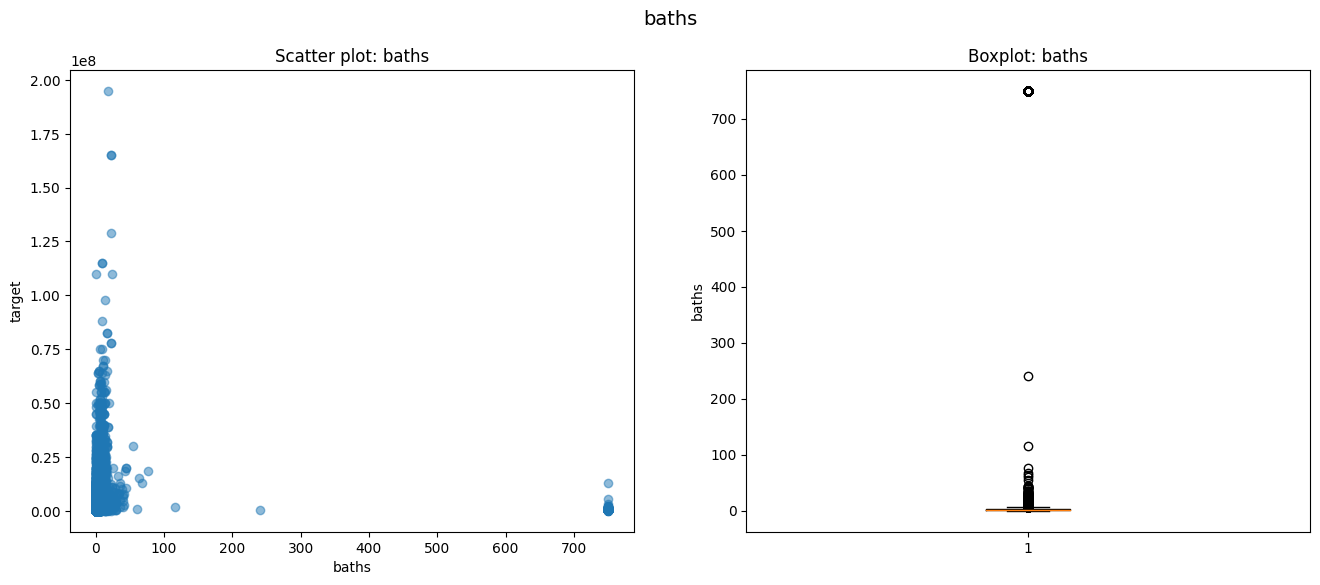

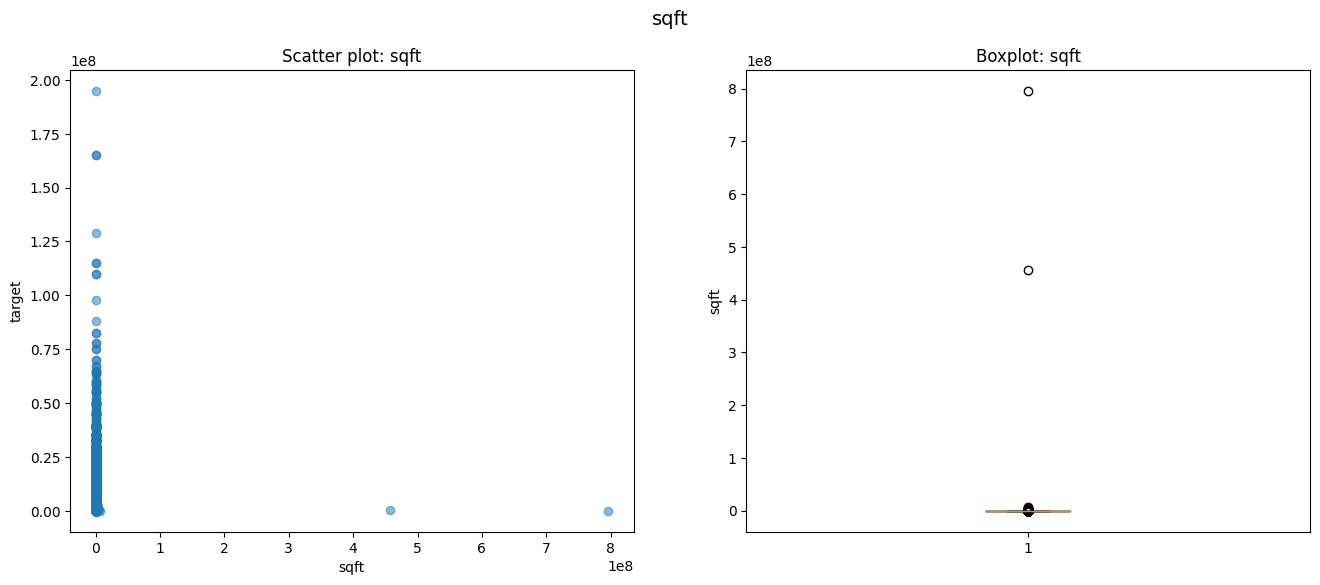

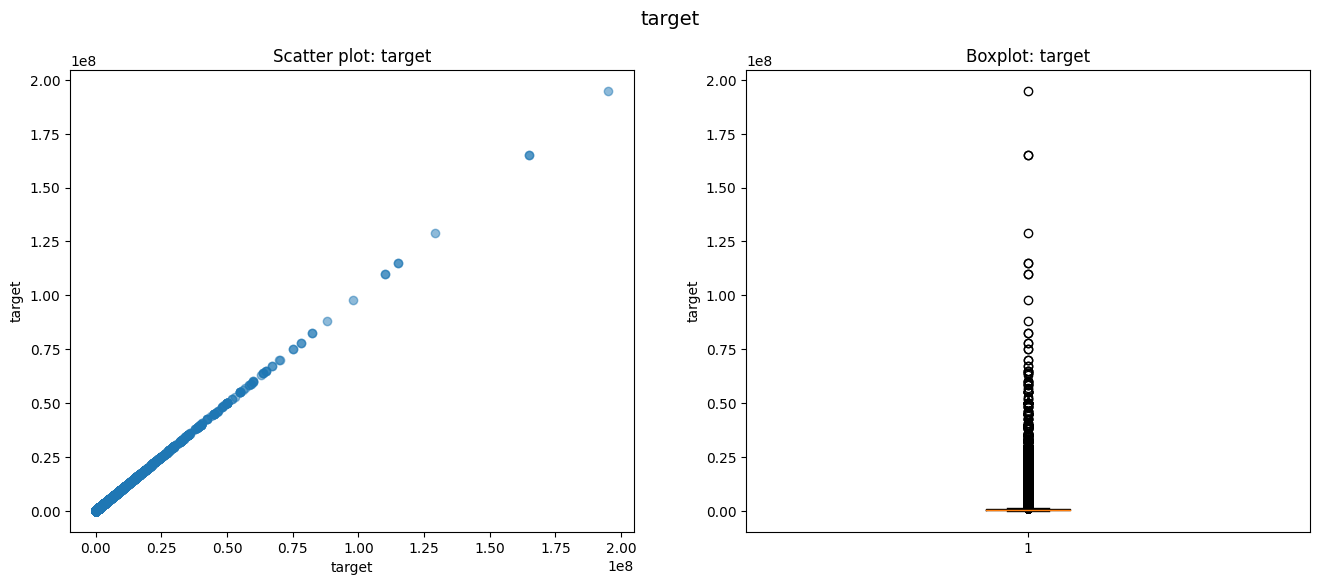

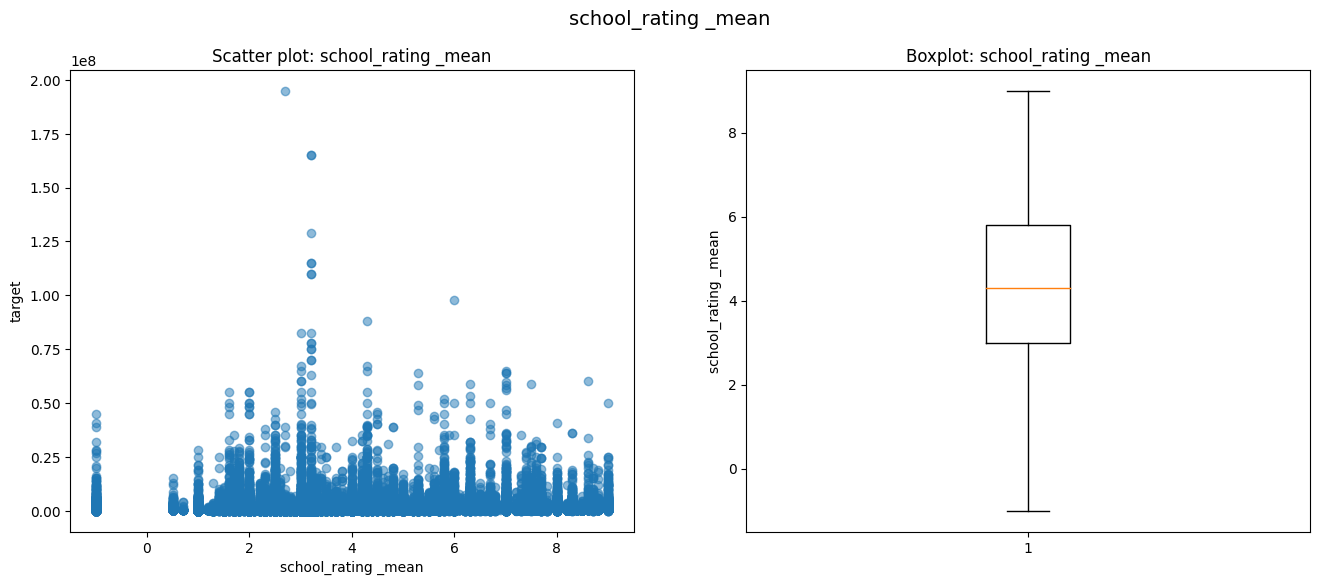

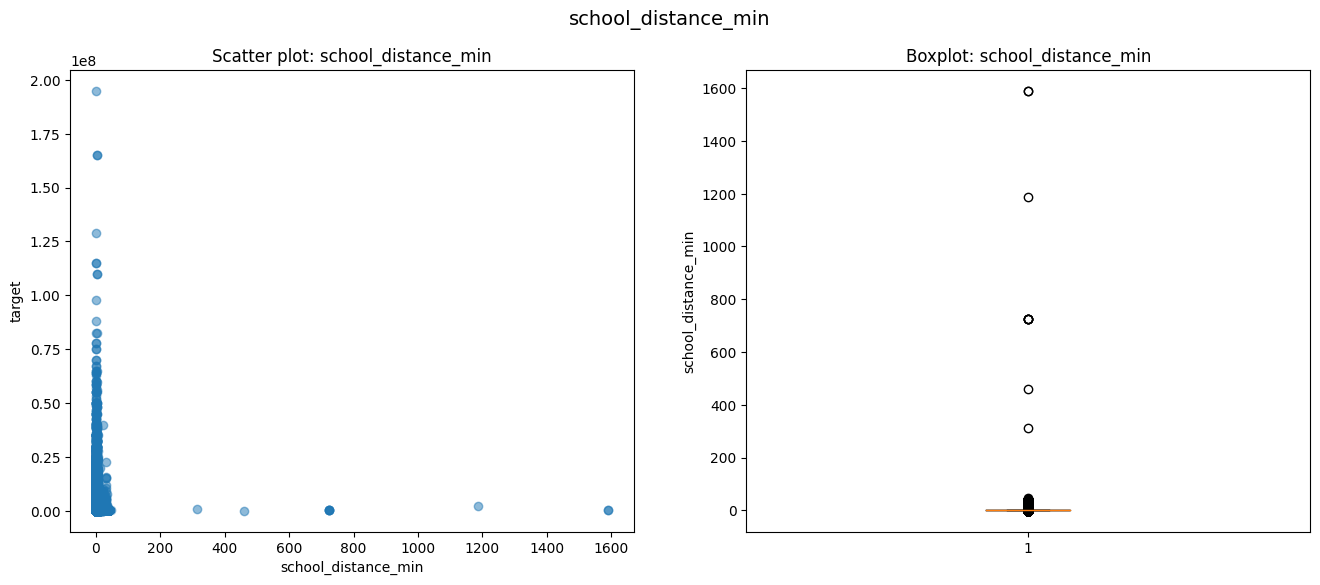

In [432]:
#Построение графиков для числовых признаков
for feature in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    #Диаграмма рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    #Коробчатая диаграмма
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()


В соответствии с построенными графиками очевидно наличие выбросов по признакам bath, sqft, school_distance_min. Данные нуждаются в дальнейшей обработке.

In [433]:
# выведем интересующие нас строки
condition = (data['baths'].isin([116,241,750]))
filtered_data = data[condition]
# Вывести отфильтрованные строки
display(filtered_data.head(5))
# Подсчет среднего значения 'sqft'
average_sqft = filtered_data['sqft'].mean()
# Вывести среднее значение 'sqft'
print("Среднее значение sqft: ", average_sqft)

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
981,Active,750.0,Dallas,1758,75219,TX,499000,False,other,1993,False,True,False,True,2.6,0.9
1788,Active,750.0,Washington,1367,20001,DC,1499000,False,other,2013,False,False,False,False,6.8,0.3
3157,Active,750.0,Denver,873,80204,CO,348900,False,other,1981,True,True,False,False,4.0,0.2
6661,Active,750.0,Denver,1864,80204,CO,560000,False,other,1936,True,False,False,False,2.0,0.5
6781,Active,750.0,Dallas,1336,75219,TX,285000,False,condo,1984,False,True,False,True,2.0,1.0


Среднее значение sqft:  2111.4725738396623


In [434]:
# Удаляем Выбросы
data.drop(data[condition].index, inplace=True)

In [435]:
condition1 = ((data['sqft'] == 0) & (data['target'] == 195000000)) | (data['sqft'] > 455000000)
filtered1_data = data[condition1]
# Вывести отфильтрованные строки
display(filtered1_data)

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
55231,For Sale,2.0,Cincinnati,795979430,45225,OH,27500,False,single_family_home,1901,True,True,True,True,2.5,0.78
116148,For Sale,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.30
328673,Active,0.0,Glendale,456602479,42740,KY,198000,False,multi_family_home,2012,True,True,False,False,6.3,3.10


In [436]:
# Удаляем Выбросы
data.drop(data[condition1].index, inplace=True)

In [437]:
condition2 = (data['school_distance_min']> 200)
filtered2_data = data[condition2]
# Вывести отфильтрованные строки
print(len(filtered2_data))
display(filtered2_data.head(5))

10


,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
23337,Other,4.0,Falcon Heights,6000,78545,TX,670000,False,single_family_home,1980,True,True,True,False,2.5,312.40
96658,For Sale,0.0,Santa Ana,890,92703,TN,48640,False,single_family_home,1963,True,True,False,True,2.7,1590.36
148607,For Sale,0.0,Spring,720,77380,TN,18000,False,single_family_home,1950,True,False,False,True,7.5,460.86
178784,For Sale,6.0,Miami Beach,4173,33140,FL,2350000,True,single_family_home,1949,True,False,True,False,5.5,1187.14
189251,For Sale,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1953,True,True,False,True,5.5,725.17


In [438]:
# Удаляем Выбросы
data.drop(data[condition2].index, inplace=True)

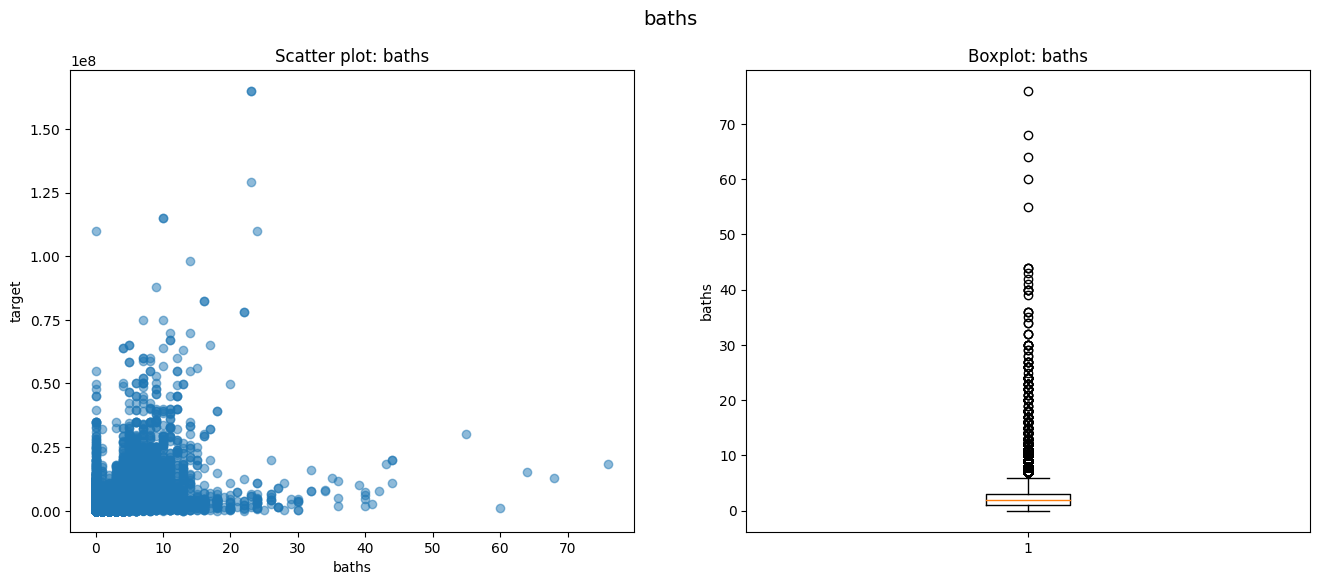

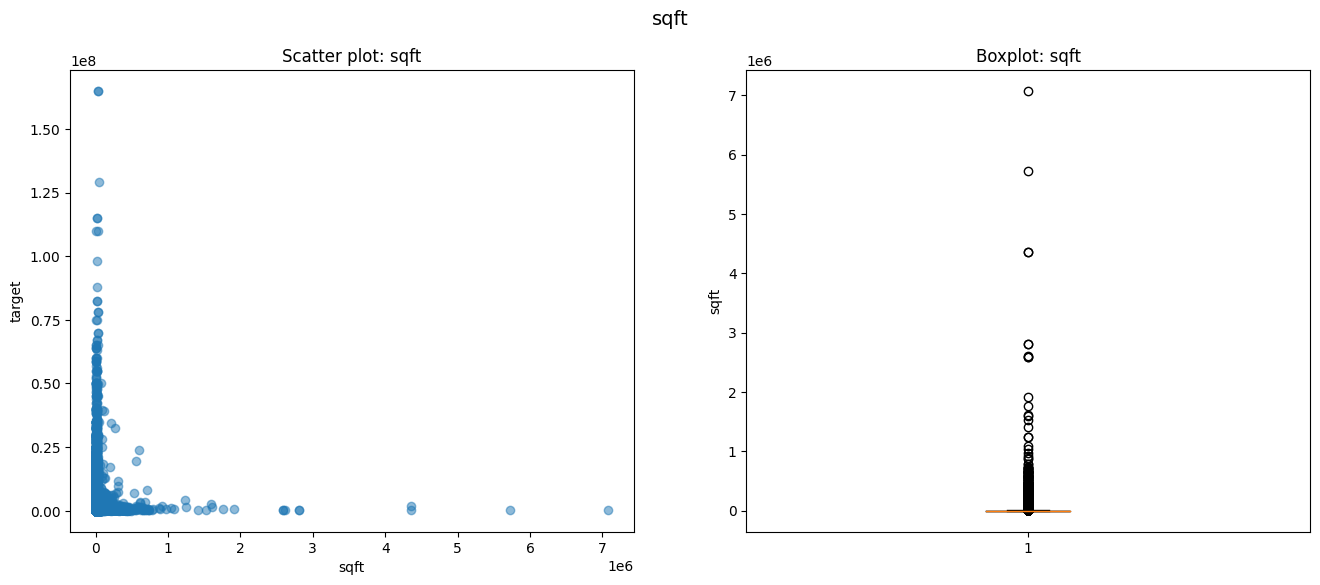

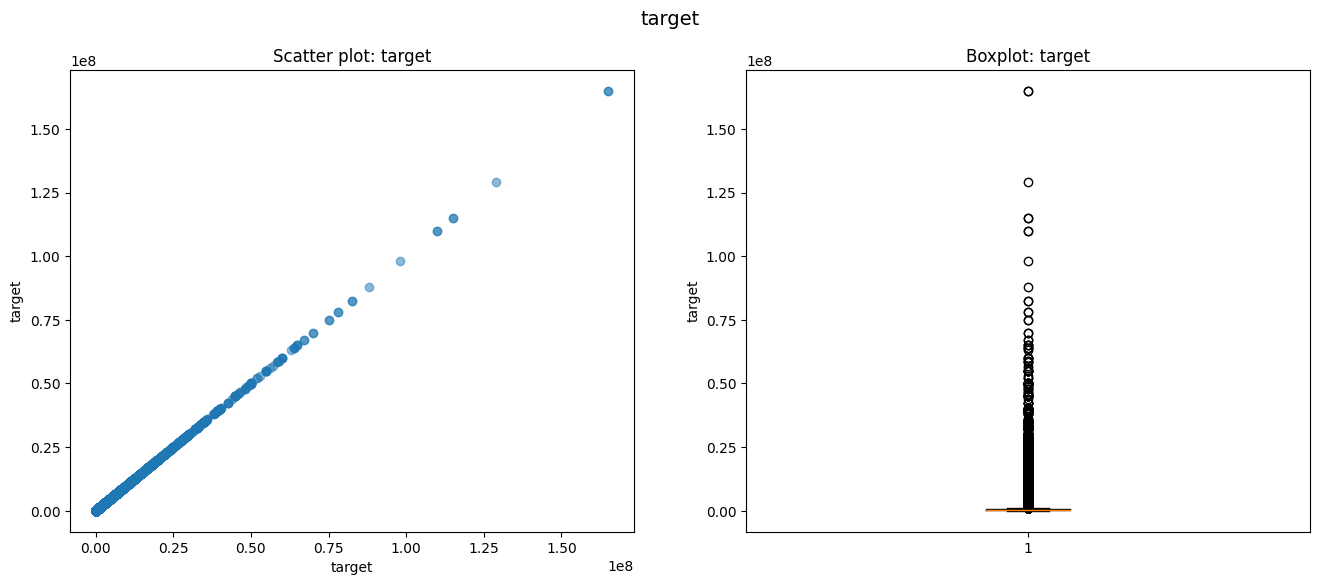

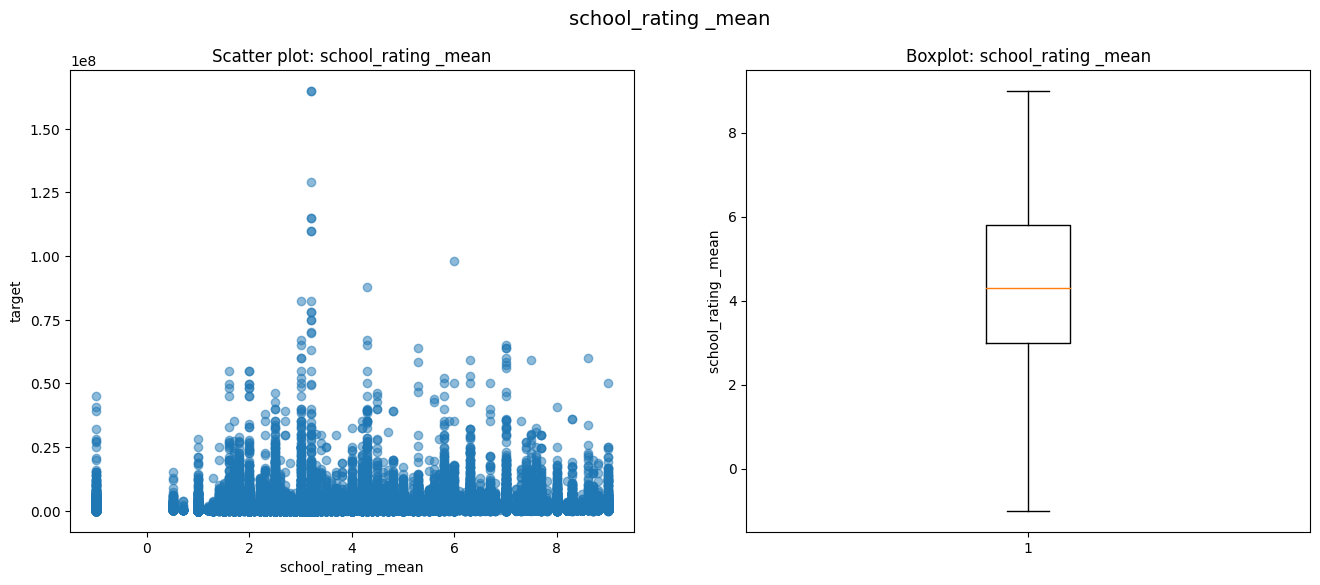

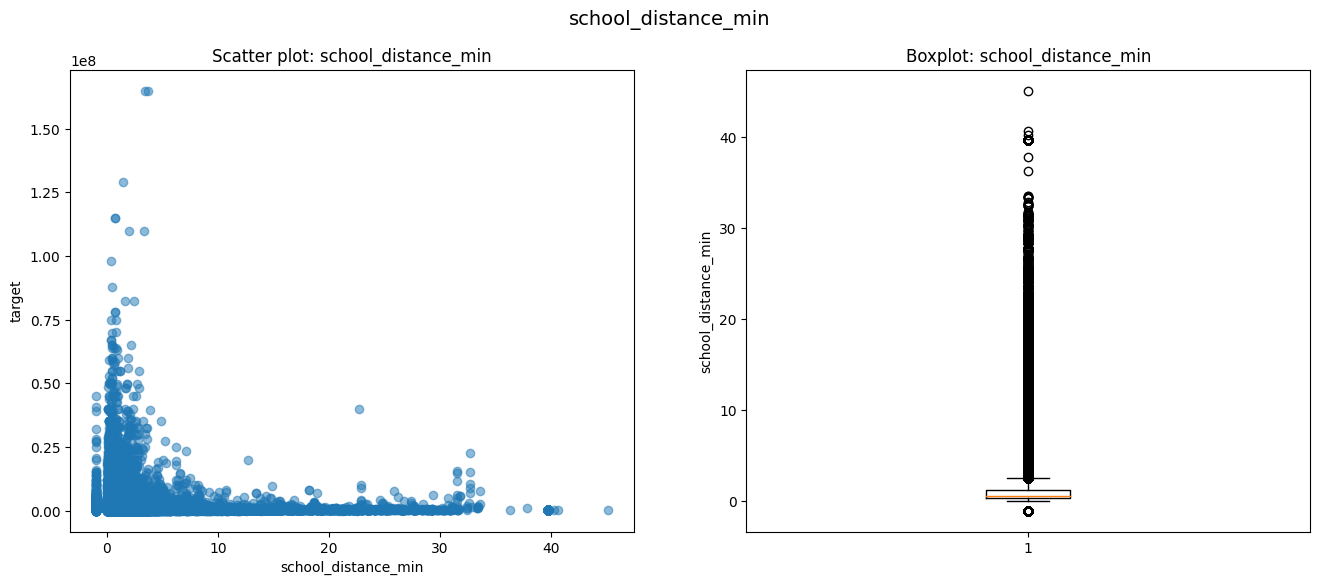

In [439]:
#Построение графиков для числовых признаков
for feature in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    #Диаграмма рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    #Коробчатая диаграмма
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

исходя из полученных графиков, выбросы до сих пор присутствуют в датасете, необходимо повторно из обработать

In [440]:
condition3 = ((data['baths'] > 30) | (data['target'] > 750000)) | (data['sqft'] > 200000) |(data['school_distance_min']> 35)
filtered3_data = data[condition3]
# Вывести отфильтрованные строки
print(len(filtered3_data))
display(filtered3_data.head(5))

58907


,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
2,For Sale,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
14,For Sale,0.0,Brooklyn,0,11219,NY,1650000,False,single_family_home,1905,False,True,False,False,6.3,0.20
16,Active,0.0,New York,3325,10027,NY,2650000,False,townhouse,1899,False,False,False,False,2.5,0.10
20,For Sale,5.0,Bend,5266,97702,OR,3500000,False,single_family_home,2008,True,True,True,True,6.3,3.70


In [441]:
# Удаляем Выбросы
data.drop(data[condition3].index, inplace=True)

In [442]:
condition4 = ((data['baths'] < 1) | (data['sqft'] < 1))
filtered4_data = data[condition4]
# Вывести отфильтрованные строки
print(len(filtered4_data))
display(filtered4_data.head(5))

61218


,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
4,For Sale,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00
5,Active,0.0,Poinciana,1507,34759,FL,181500,False,other,2006,True,True,False,False,2.3,0.80
6,Active,0.0,Memphis,0,38115,TN,68000,False,other,1976,False,False,False,False,2.7,0.40
10,Active,0.0,Houston,3130,77068,TX,260000,False,other,2015,True,True,False,False,4.2,0.40
34,For Sale,0.0,Charlotte,900,28202,NC,260000,False,condo,1981,False,False,False,False,6.3,0.48


In [443]:
# Удаляем Выбросы
data.drop(data[condition4].index, inplace=True)

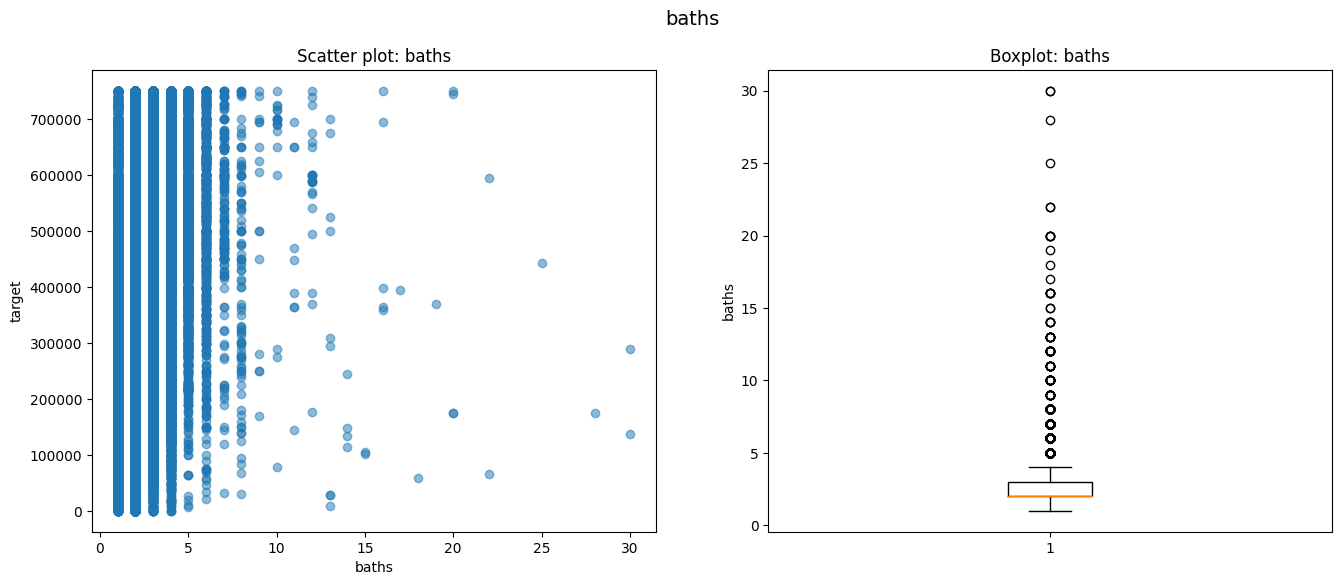

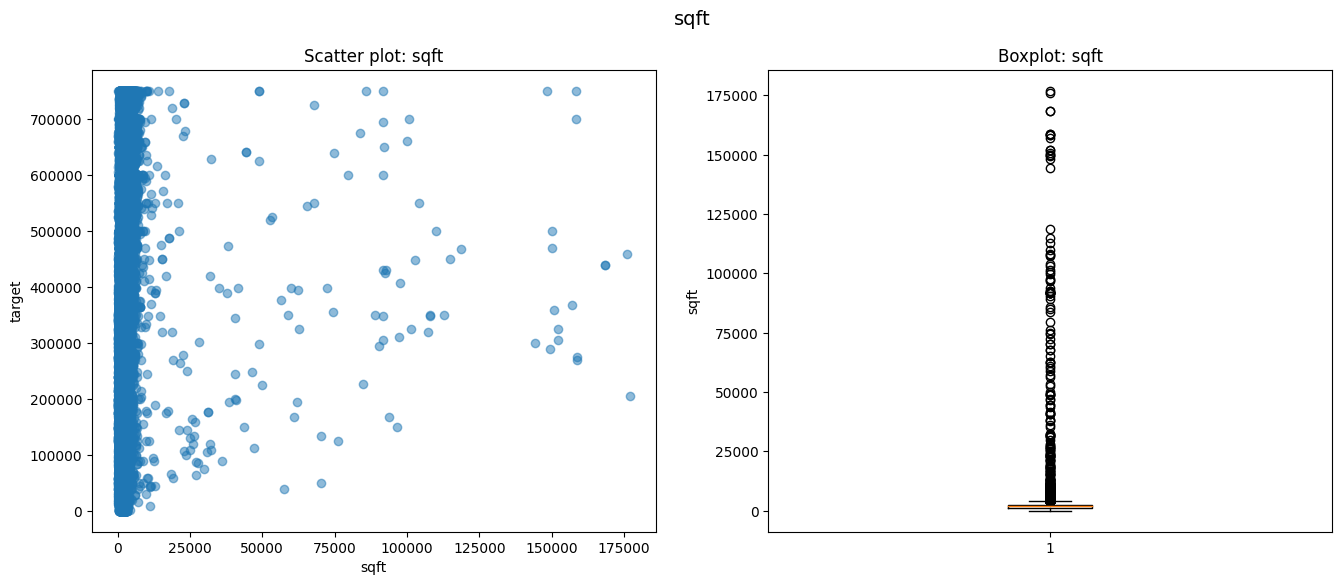

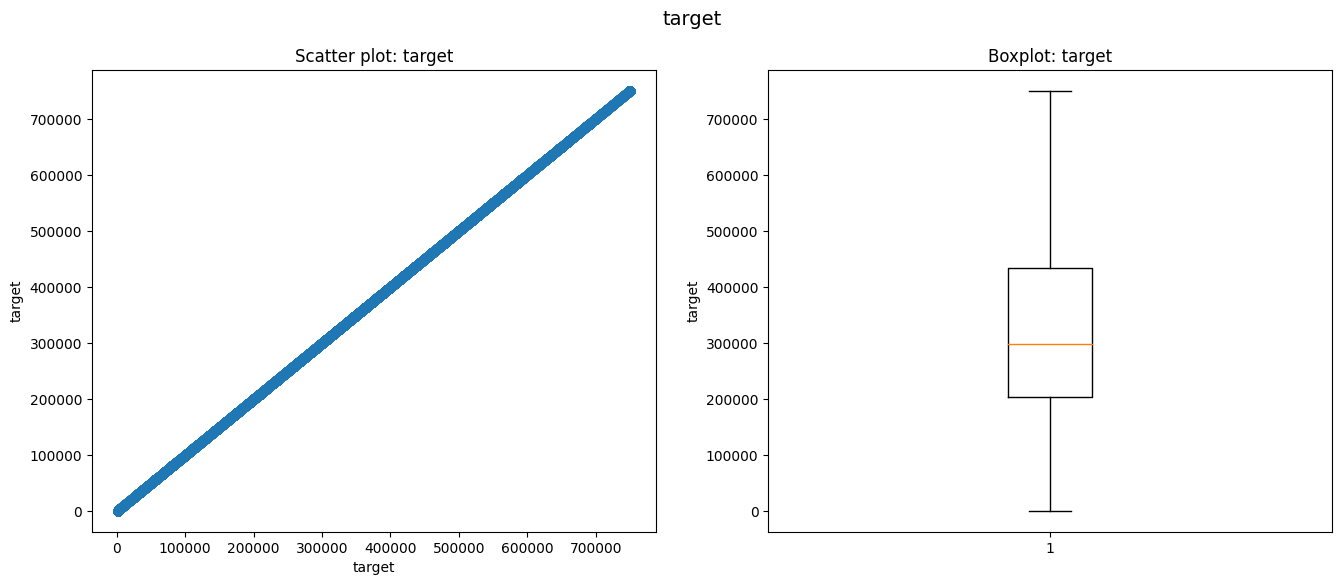

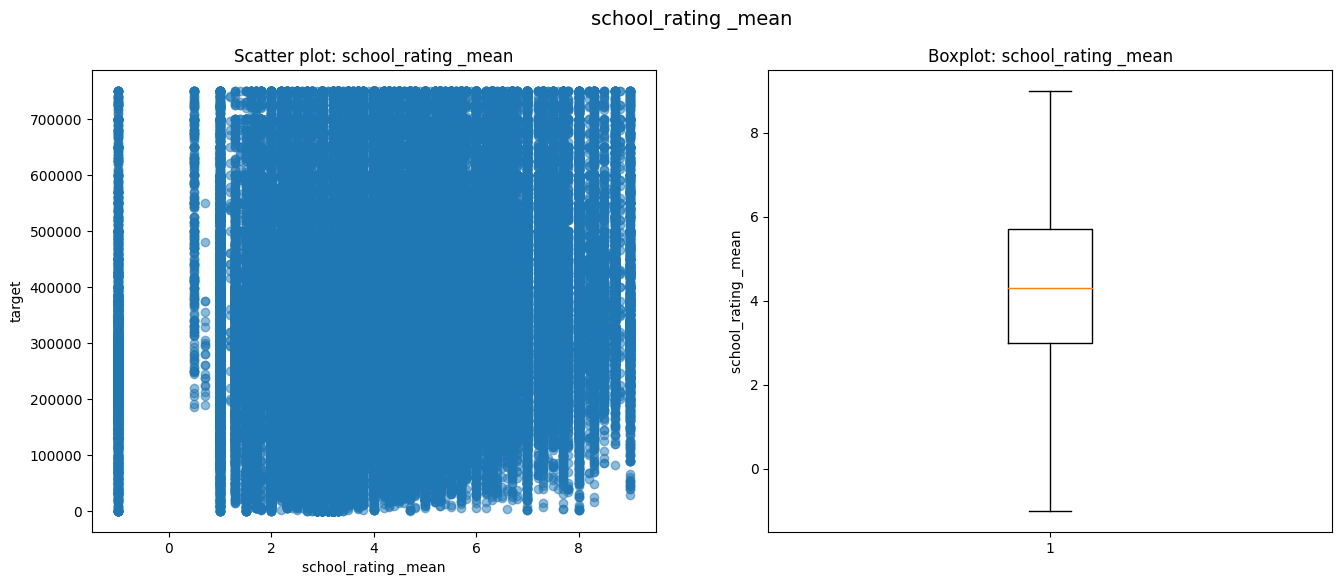

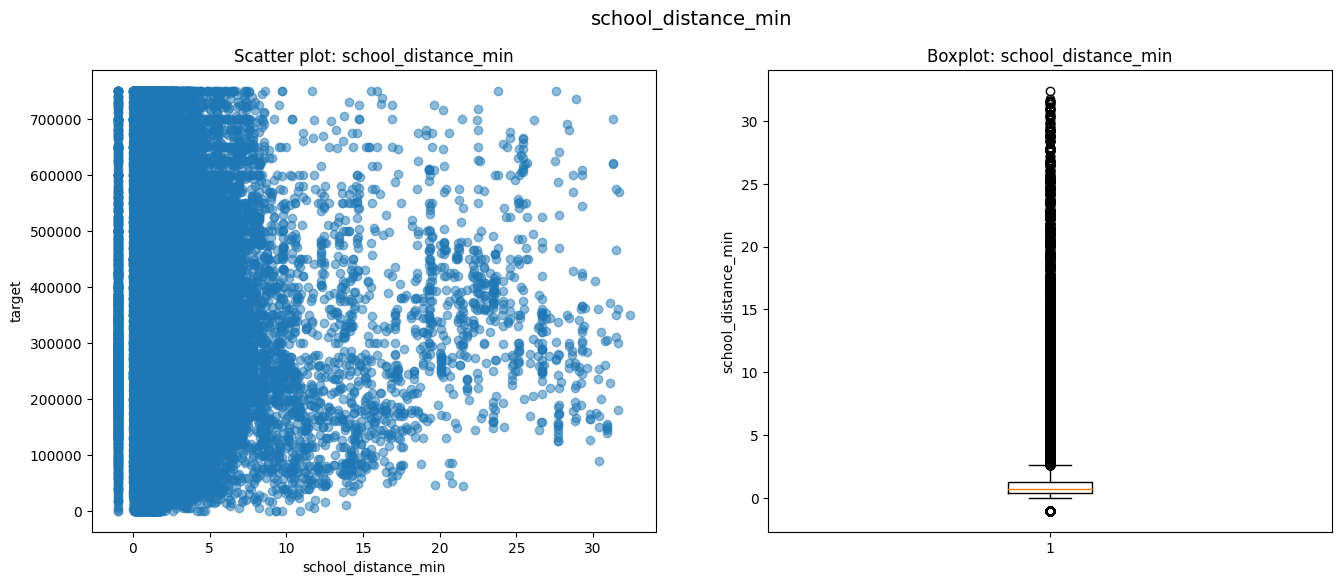

In [444]:
#Построение графиков для числовых признаков
for feature in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    #Диаграмма рассеивания
    ax1.scatter(data[feature], data['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    #Коробчатая диаграмма
    ax2.boxplot(data[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

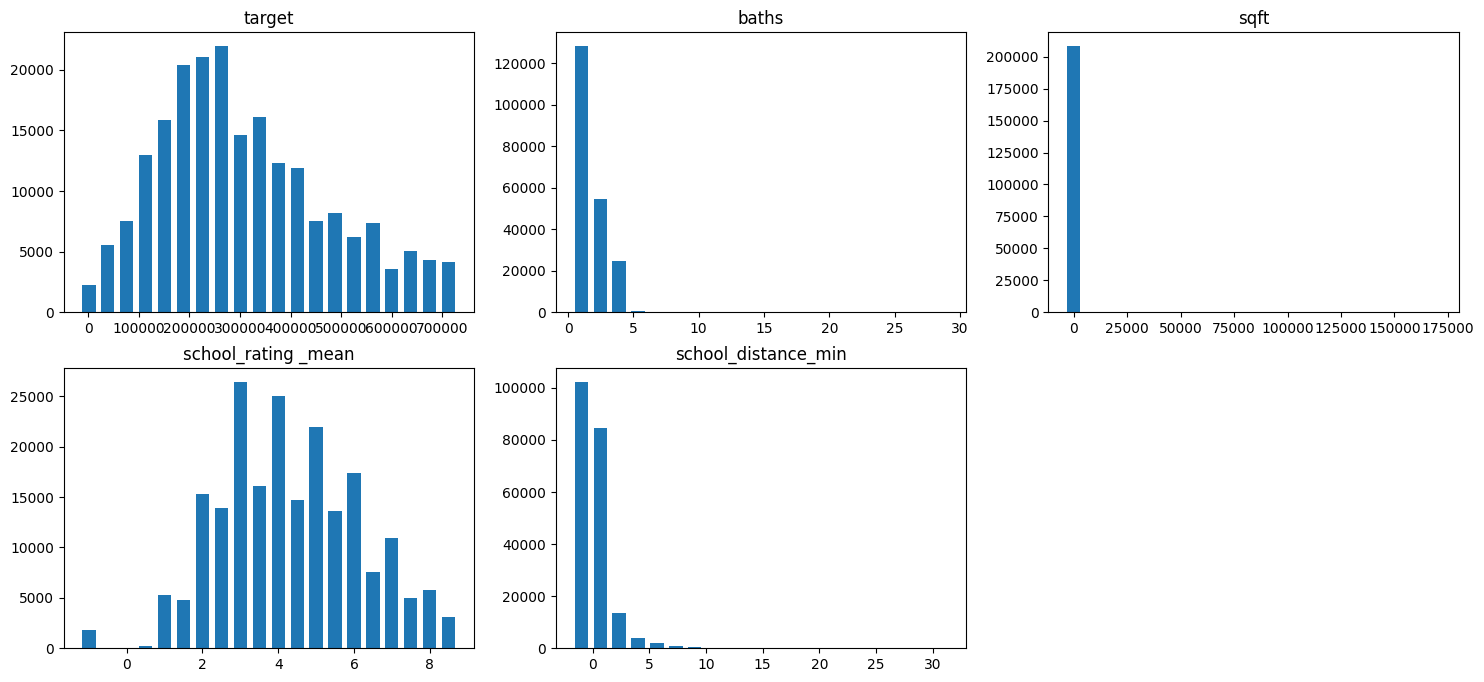

In [450]:
#Построим гистограмму для наглядности распределения числовых признаков
visualize_distributions({
    'target': data['target'],
    'baths': data['baths'],
    'sqft': data['sqft'],
    'school_rating _mean': data['school_rating _mean'],
    'school_distance_min': data['school_distance_min'],
})

Анализ категориальных признаков

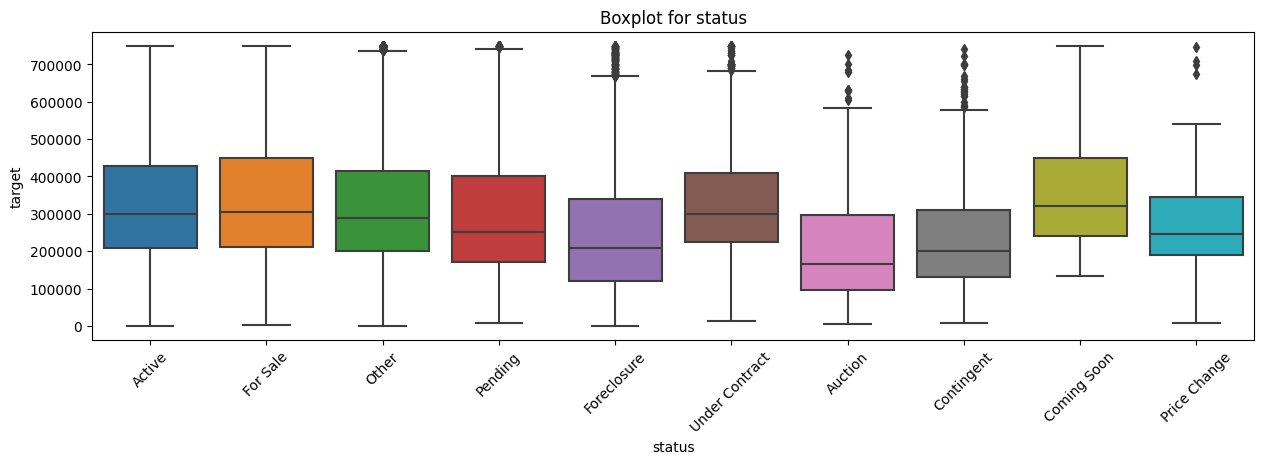

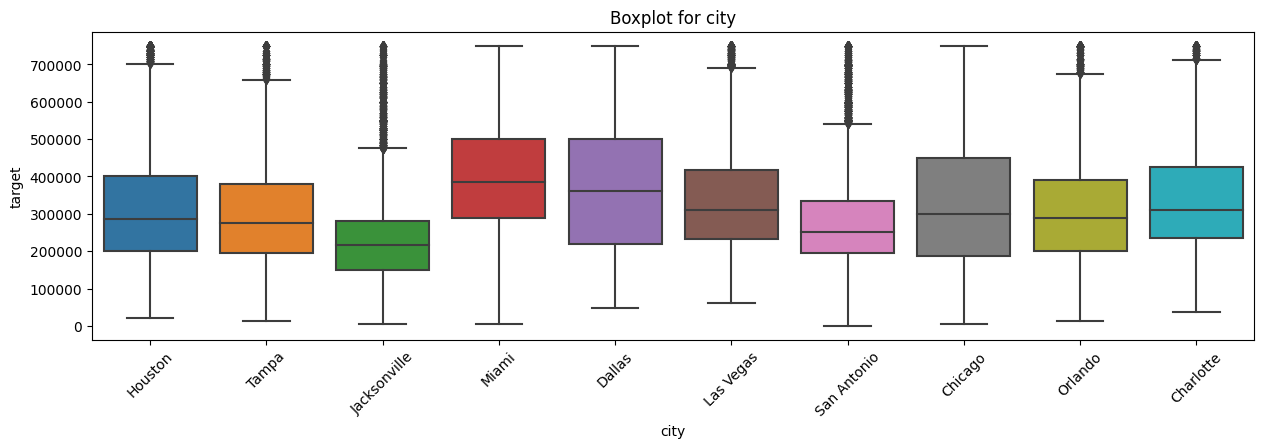

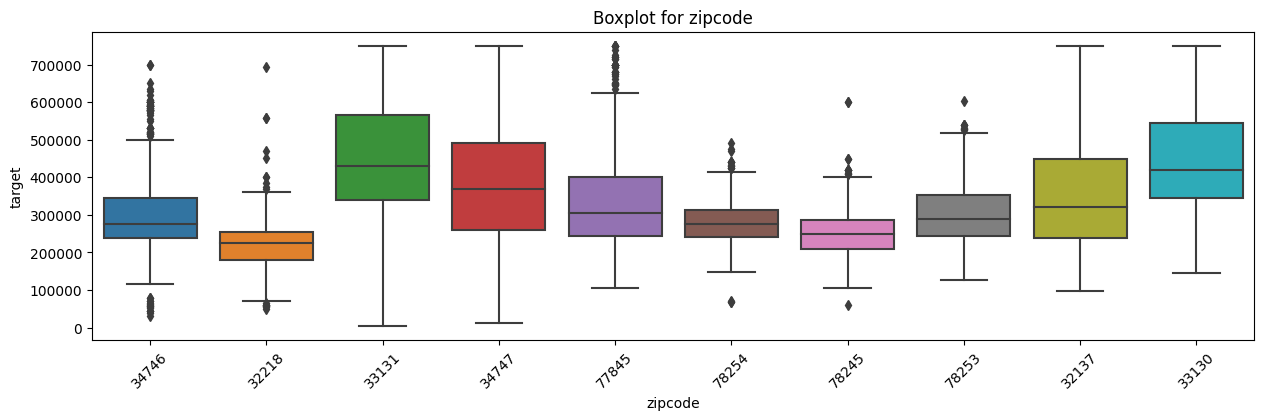

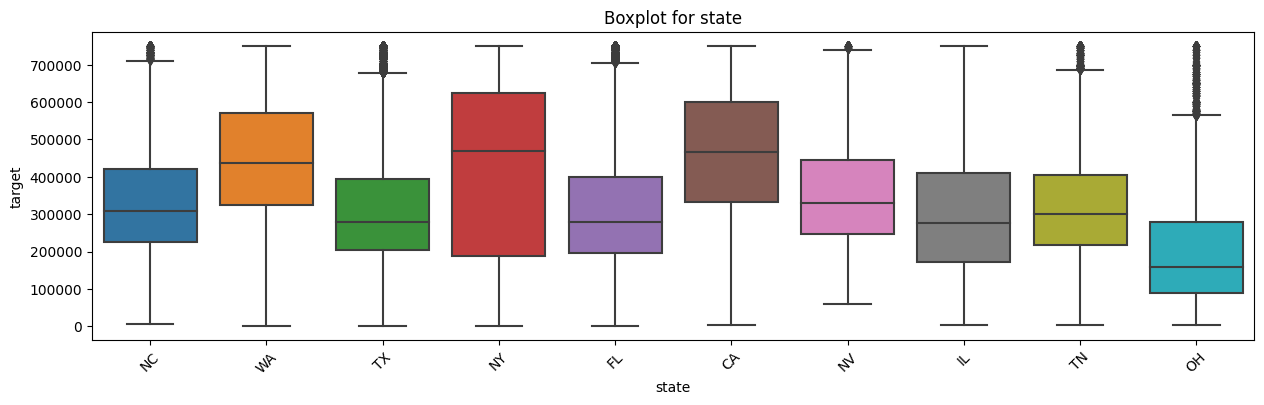

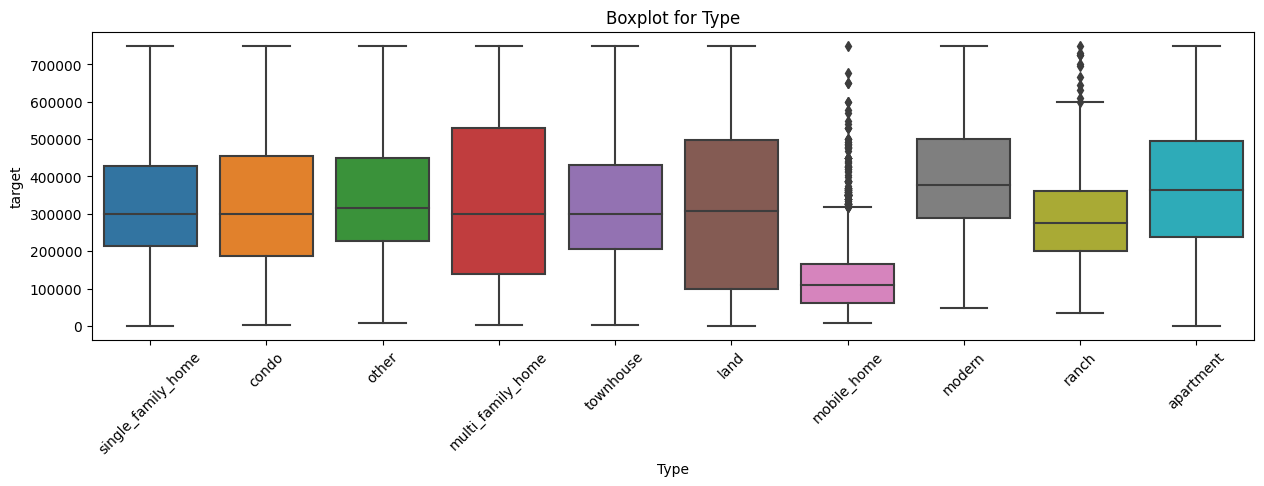

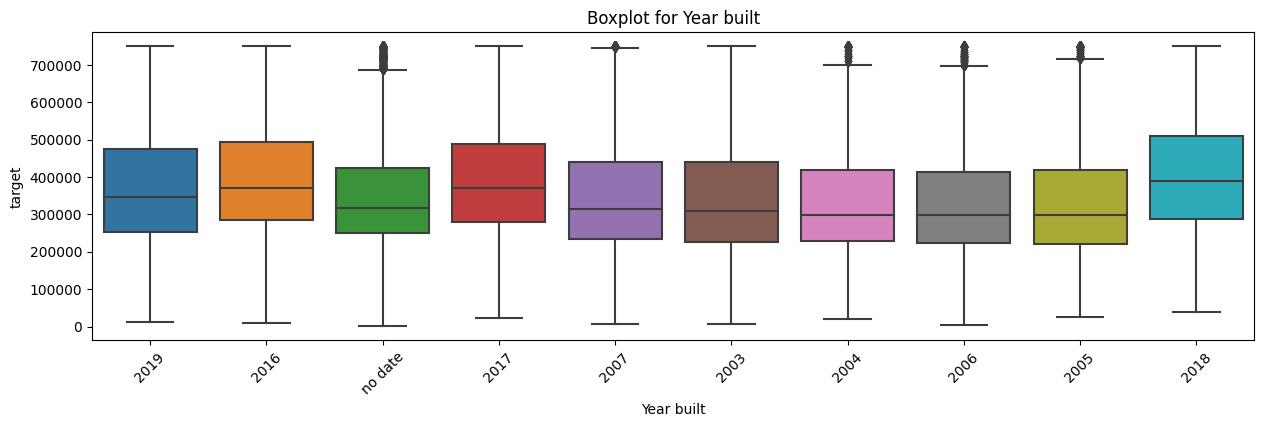

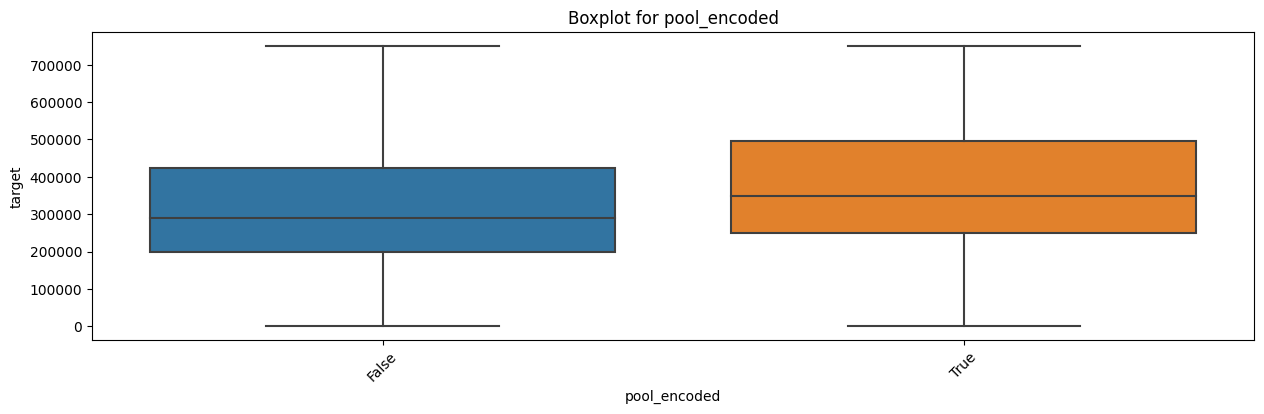

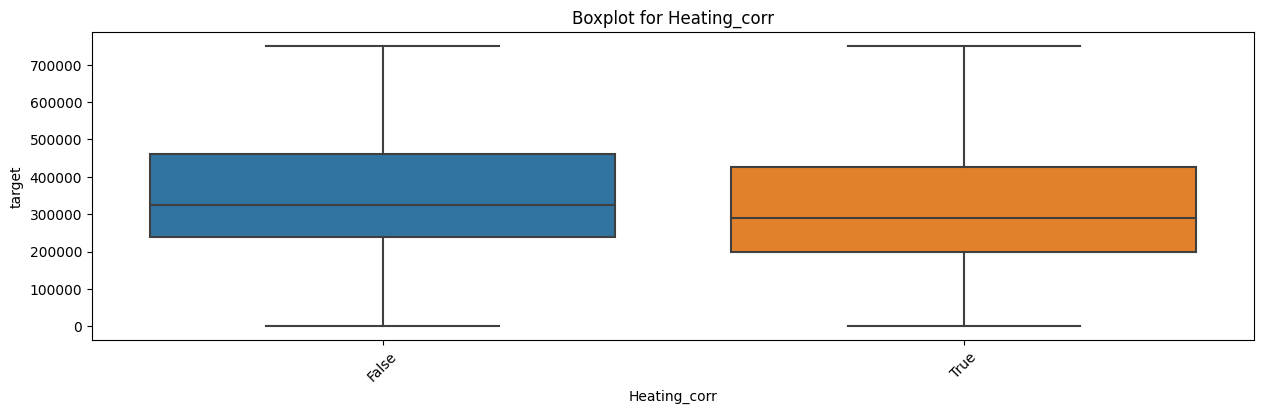

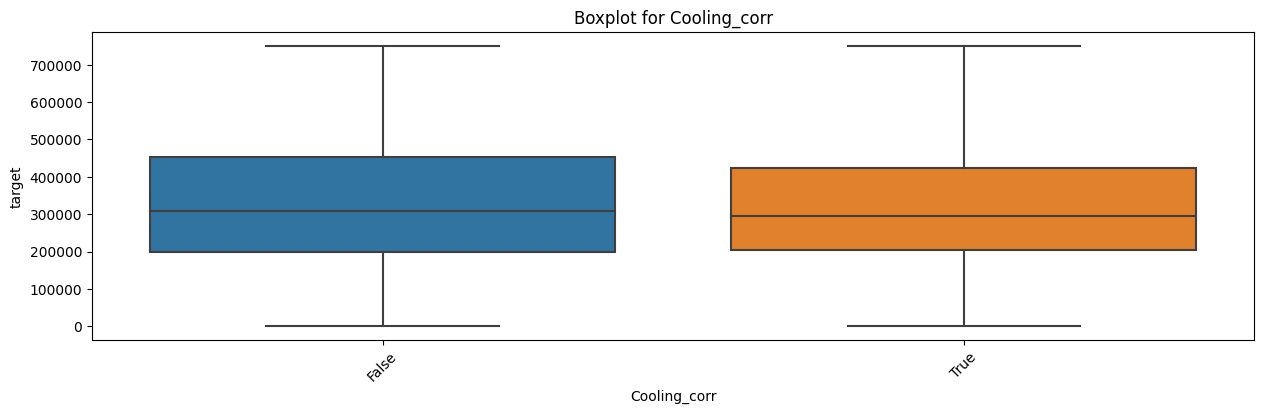

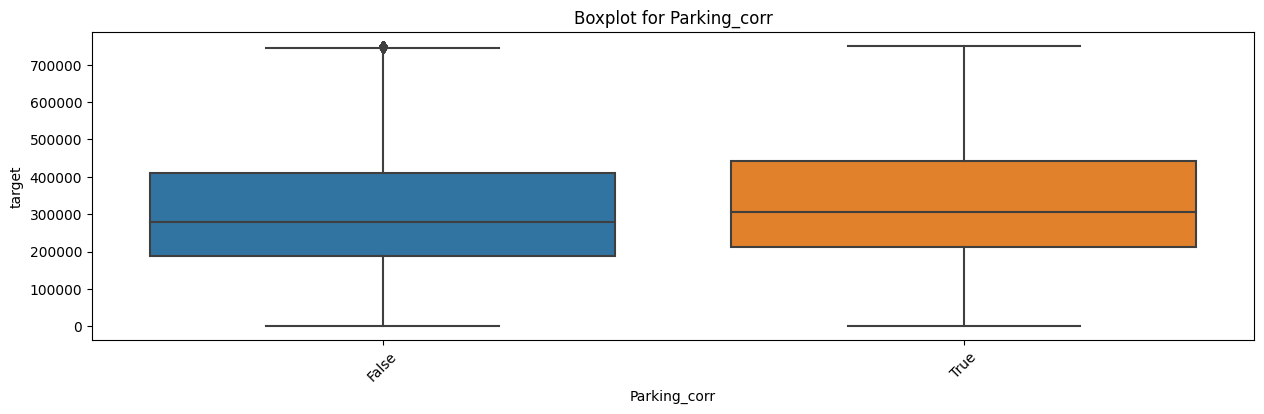

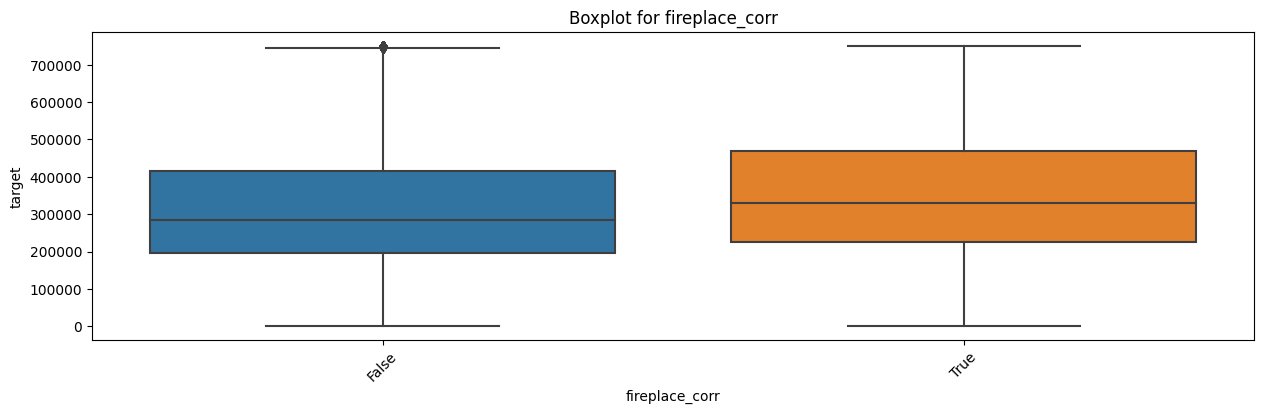

In [453]:
#Распределение стоимости квартир в зависимости от категориальных переменных
for col in chain(categorial_features, bul_features):
    get_boxplot(col)

Вывод: По итогам проведенного разведовательного анализа данных, было выполнено снижение размерности данных, а именно некоторые признаки были удалены, некоторые признаки были десериализованы и из них созданы новые признаки, некоторые предобработаны для дальнейшего анализа данных и поиска выбросов. С помощью визуализации были обнаружены и удалены выбросы и пропуски, которые влияют на целевую переменную.

In [454]:
data.to_csv('formodel_data.csv', index=False)

Создание модели

In [458]:
import random
import numpy as np 
import pandas as pd 
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm.notebook import tqdm
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [459]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
TEST_SIZE = 0.2

In [461]:
data = pd.read_csv('formodel_data.csv')
display(data.head(5))
data.info()

,status,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min
0,Active,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,Active,2.0,Mason,3588,50401,IA,244900,False,single_family_home,1970,True,True,False,False,3.8,5.60
3,Other,3.0,Houston,1930,77080,TX,311995,False,single_family_home,2019,True,True,True,False,3.0,0.60
4,For Sale,2.0,Flushing,1300,11354,NY,669000,False,condo,1965,False,False,True,False,2.8,0.30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208859 entries, 0 to 208858
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               208859 non-null  object 
 1   baths                208859 non-null  float64
 2   city                 208859 non-null  object 
 3   sqft                 208859 non-null  int64  
 4   zipcode              208859 non-null  int64  
 5   state                208859 non-null  object 
 6   target               208859 non-null  int64  
 7   pool_encoded         208859 non-null  bool   
 8   Type                 208859 non-null  object 
 9   Year built           208859 non-null  object 
 10  Heating_corr         208859 non-null  bool   
 11  Cooling_corr         208859 non-null  bool   
 12  Parking_corr         208859 non-null  bool   
 13  fireplace_corr       208859 non-null  bool   
 14  school_rating _mean  208859 non-null  float64
 15  school_distance_m

In [462]:
#Определение списка булевых признаков:
bul_features = ['pool_encoded','Heating_corr','Cooling_corr','Parking_corr','fireplace_corr']

#Определение списка категориальных признаков:
categorial_features = ['status','city','zipcode','state','Type','Year built']
 
#Определение списка числовых признаков:
numeric_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_distance_min']

In [464]:
#Определение количества уникальных значений в каждом категориальном признаке
for col in categorial_features:
   unique_values = data[col].nunique()
   print(f"Количество уникальных значений в категориальной колонке {col}: {unique_values}")

Количество уникальных значений в категориальной колонке status: 12
Количество уникальных значений в категориальной колонке city: 1522
Количество уникальных значений в категориальной колонке zipcode: 3962
Количество уникальных значений в категориальной колонке state: 34
Количество уникальных значений в категориальной колонке Type: 12
Количество уникальных значений в категориальной колонке Year built: 205


In [465]:
def preproc_data(data_input):
    
    data_output = data_input.copy()
    #Переведем признак Zipcode в категориальный
    data_output['zipcode'] = data_output['zipcode'].astype(str)
    #Переведем признак Year built в категориальный
    data_output['Year built'] = data_output['Year built'].astype(str)
    # Нормализация данных
    for column in ['baths', 'sqft', 'target', 'school_rating _mean', 'school_distance_min']:
       
        data_output[column] = data_output[column].apply(lambda x: abs(x))
        constant = 1e-6
        data_output[column] = np.log(data_output[column] + constant)
        
 
    ohe_status = OneHotEncoder(sparse=False)
    ohe_state = OneHotEncoder(sparse=False)
    ohe_Type = OneHotEncoder(sparse=False)

    status_ohe = ohe_status.fit_transform(data_output['status'].values.reshape(-1,1))
    state_ohe = ohe_state.fit_transform(data_output['state'].values.reshape(-1,1))
    Type_ohe = ohe_Type.fit_transform(data_output['Type'].values.reshape(-1,1))

    le = LabelEncoder()
    state_label = le.fit_transform(data_output['state'])

    year_le = LabelEncoder()
    year_ord = year_le.fit_transform(data_output['Year built'])

    city_le = LabelEncoder()
    city_label = city_le.fit_transform(data_output['city'])

    zip_le = LabelEncoder()
    zip_label = zip_le.fit_transform(data_output['zipcode'])

    #Добавление нормализованных категориальных объектов в базу данных
    data_output = data_output.join(pd.DataFrame(status_ohe, columns=['status_' + str(cat) for cat in ohe_status.categories_[0]]))
    data_output = data_output.join(pd.DataFrame(state_ohe, columns=['state_' + str(cat) for cat in ohe_state.categories_[0]]))
    data_output = data_output.join(pd.DataFrame(Type_ohe, columns=['Type_' + str(cat) for cat in ohe_Type.categories_[0]]))
    data_output['state_label'] = state_label
    data_output['year_ord'] = year_ord
    data_output['city_label'] = city_label
    data_output['zip_label'] = zip_label

    #Удаление неактуальных категориальных признаков
    data_output.drop(['status', 'state', 'Type', 'city', 'zipcode','Year built'], axis=1, inplace=True)
    
    return data_output

In [466]:
# Запускаем и проверяем, что получилось
data_encoded = preproc_data(data)
data_encoded.sample(10)

,baths,sqft,target,pool_encoded,Heating_corr,Cooling_corr,Parking_corr,fireplace_corr,school_rating _mean,school_distance_min,...,Type_modern,Type_multi_family_home,Type_other,Type_ranch,Type_single_family_home,Type_townhouse,state_label,year_ord,city_label,zip_label
42100,1.098613,7.934155,12.923912,False,True,False,True,False,1.547563,-1.560643,...,0.0,0.0,0.0,0.0,1.0,0.0,24,94,1065,3738
114472,0.693148,6.935370,12.611538,False,True,True,True,True,1.902108,-0.693145,...,0.0,0.0,0.0,0.0,0.0,0.0,32,176,425,3854
146011,0.693148,7.885705,12.923912,False,True,True,True,False,1.740466,-0.105359,...,0.0,0.0,0.0,0.0,1.0,0.0,20,172,727,3084
30964,0.693148,7.703459,12.793165,False,True,True,True,False,1.458615,-0.105359,...,0.0,0.0,0.0,0.0,1.0,0.0,5,172,644,912
157773,1.098613,7.668094,13.100118,False,False,True,False,False,1.386295,2.069391,...,0.0,0.0,0.0,0.0,1.0,0.0,5,204,1347,940
52021,1.098613,7.682482,12.288113,False,True,True,True,False,0.832910,-0.105359,...,0.0,0.0,0.0,0.0,1.0,0.0,6,201,56,806
21905,0.693148,7.156956,12.449019,False,True,True,True,False,0.788458,0.587787,...,0.0,0.0,0.0,0.0,0.0,0.0,5,189,1467,1138
101178,0.693148,7.264030,11.848683,False,True,True,True,False,1.163151,-1.609433,...,0.0,0.0,0.0,0.0,1.0,0.0,18,124,229,728
108623,1.098613,7.529406,12.983101,False,True,True,True,False,2.041220,-0.616184,...,0.0,0.0,0.0,0.0,1.0,0.0,5,177,856,1038
19709,1.098613,7.257003,12.354062,False,True,True,False,False,2.079442,-0.162518,...,0.0,0.0,0.0,0.0,1.0,0.0,28,201,1182,2666


In [467]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208859 entries, 0 to 208858
Data columns (total 72 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   baths                    208859 non-null  float64
 1   sqft                     208859 non-null  float64
 2   target                   208859 non-null  float64
 3   pool_encoded             208859 non-null  bool   
 4   Heating_corr             208859 non-null  bool   
 5   Cooling_corr             208859 non-null  bool   
 6   Parking_corr             208859 non-null  bool   
 7   fireplace_corr           208859 non-null  bool   
 8   school_rating _mean      208859 non-null  float64
 9   school_distance_min      208859 non-null  float64
 10  status_Active            208859 non-null  float64
 11  status_Auction           208859 non-null  float64
 12  status_Back on Market    208859 non-null  float64
 13  status_Coming Soon       208859 non-null  float64
 14  stat

In [468]:
#Разбивка датасета на обучающую и тестовую выборки

y = data_encoded.target.values
X = data_encoded.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

Обучение модели

1. LinearRegression

In [469]:
#Создание модели линейной регрессии
model = LinearRegression(fit_intercept=False)

#Обучение модели
model.fit(X_train, y_train)

#Предсказания на обучающих и тестовых данных
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Метрики качества модели
mse_train = metrics.mean_squared_error(y_train, y_train_pred)
mse_test = metrics.mean_squared_error(y_test, y_test_pred)
mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.23
Test MSE: 0.24
Train MAE: 0.35
Test MAE: 0.35
Train R2: 0.45
Test R2: 0.45


Низкие значения MSE указывают на более точные предсказания модели.

Низкие значения MAE также говорят о хорошей точности предсказания.

Коэффициент детерминации (R2) В данном случае R2 составляет 0.45 как для обучающей, так и для тестовой выборки, что означает, что модель объясняет 45% дисперсии зависимой переменной.

Результаты модели показывают, что она работает с одинаковой точностью на обучающем и тестовом наборе данных, что свидетельствует о том, что модель не переобучилась. Однако, коэффициент детерминации R2 достаточно высокий.

2. RandomForestRegressor

In [470]:
#Создание модели RandomForestRegressor
regressor = RandomForestRegressor(random_state=RANDOM_SEED)

#Обучение модели
regressor.fit(X_train, y_train)

#Предсказания на обучающих и тестовых данных
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

#Метрики качества модели
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)


print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.01
Test MSE: 0.07
Train MAE: 0.06
Test MAE: 0.17
Train R2: 0.98
Test R2: 0.84


Значения MSE для обучающей выборки 0.01 и 0.07 для тестовой - может указывать на небольшое переобучение модели.

Значения MAE для обучающей выборки 0.06 и 0.17 для тестовой - может указывать на небольшое переобучение модели.

Коэффициент детерминации R2 равеный 0.98 для обучающей выборки и 0.84 для тестовой - указывают на то, что модель хорошо работает на обучающей выборке и хорошо предсказывает на тестовой, однако значение R2 на тестовой выборке заметно ниже, что также может указывать на небольшое переобучение модели.

Модель достаточно эффективна.

3. ElasticNetCV

In [471]:
#Создание модели ElasticNetCV 
model_el = ElasticNetCV(cv=5, random_state=RANDOM_SEED)
model_el.fit(X_train, y_train)

##Предсказания на обучающих и тестовых данных
y_train_pred = model_el.predict(X_train)
y_test_pred = model_el.predict(X_test)

#Метрики качества модели
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.38
Test MSE: 0.38
Train MAE: 0.45
Test MAE: 0.45
Train R2: 0.12
Test R2: 0.12


MSE - в данном случае обучающая и тестовая выборка имеют значение 0.38. Это означает, что модель не переобучилась, но в то же время обобщающая способность модели может быть не очень хорошей из-за высоких значений ошибок.

MAE - в данном случае средняя абсолютная ошибка составляет 0.45 как для обучающей, так и для тестовой выборки. Это означает, что в среднем модель ошибается на 0.45 при предсказаниях.

R2 - в данном случае равен 0.12 для обучающей выборки и 0.12 для тестовой выборки. Это значение невысоко, что говорит о плохом качестве модели и низкой способности объяснить изменчивость данных.

Вывод: по представленным результатам видно, что модель имеет среднюю ошибку и невысокий коэффициент детерминации. Модель не является оптимальной.

In [473]:
df = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2'],
        'LinearRegression': [0.23, 0.24, 0.35, 0.35, 0.45, 0.45],
        'RandomForestRegressor': [0.01, 0.07, 0.06, 0.17, 0.98, 0.84],
        'ElasticNetCV': [0.38, 0.38, 0.45, 0.45, 0.12, 0.12]}

data_metric = pd.DataFrame(df)
data_metric.head(6)

,Metric,LinearRegression,RandomForestRegressor,ElasticNetCV
0,Train MSE,0.23,0.01,0.38
1,Test MSE,0.24,0.07,0.38
2,Train MAE,0.35,0.06,0.45
3,Test MAE,0.35,0.17,0.45
4,Train R2,0.45,0.98,0.12
5,Test R2,0.45,0.84,0.12


На основе этих результатов, RandomForestRegressor кажется наилучшей моделью, так как она имеет наименьший показатель ошибок MSE и MAE, вместе с высоким коэффициентом детерминации R2 (0.84) на тестовых данных. 

In [474]:
import pickle

In [477]:
model_m = pickle.dumps(regressor)
print(type(model_m))
print(type(regressor))

<class 'bytes'>
<class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [478]:
# Сохранение выбранной обученной модели в файл pickle для дальнейшей передачи в деплой.
with open('regressor.pkl', 'wb') as output: 
    pickle.dump(regressor, output)